In [2]:
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import scipy
import pandas as pd
import numpy as np
from sunpy.time import parse_time

from astropy.modeling import models, fitting
import astropy.units as u
from astropy import constants as const
from astropy.stats import gaussian_sigma_to_fwhm,gaussian_fwhm_to_sigma


from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import parse_time
from sunpy.timeseries import TimeSeries

import datetime
import pickle
import importlib
import json
import time
import glob
import os

with open('data/selected_band.pkl','rb') as f:
    selected_band = pickle.load(f)

wavelength_full = np.load('data/wavelength_full.npz')['wavelength_full']

# test time range

In [2]:
index=3
with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
    fit_df=pickle.load(file)

In [6]:
t_start = "2012-03-07T06:00:00"
t_end = "2012-03-07T08:00:00"

# Converting to pandas datetime objects
t_start = pd.to_datetime(t_start)
t_end = pd.to_datetime(t_end)

fit_df_crop=fit_df[(fit_df['time']<t_end)&(fit_df['time']>t_start)]

In [7]:
fit_df_crop

time  amplitude       mean    stddev  \
5767920 2012-03-07 06:00:03   0.000041  15.426937  0.049113   
5767921 2012-03-07 06:00:13   0.000042  15.427681  0.048064   
5767922 2012-03-07 06:00:23   0.000043  15.426027  0.045442   
5767923 2012-03-07 06:00:33   0.000040  15.427317  0.049142   
5767924 2012-03-07 06:00:43   0.000042  15.425514  0.047463   
...                     ...        ...        ...       ...   
5768635 2012-03-07 07:59:13   0.000042  15.426514  0.047234   
5768636 2012-03-07 07:59:23   0.000043  15.424346  0.045997   
5768637 2012-03-07 07:59:33   0.000041  15.425736  0.047678   
5768638 2012-03-07 07:59:43   0.000040  15.424466  0.050805   
5768639 2012-03-07 07:59:53   0.000041  15.424529  0.050021   

                                                      pcov  eclipse_flag  
5767920  [[5.342906207708645e-12, 9.144858436358722e-10...             0  
5767921  [[6.236086943227429e-12, 9.122698007792221e-10...             0  
5767922  [[6.590748917482744e-12, 8.196870368943646e-10...             0  
5767923  [[6.793514013669533e-12, 1.1621789418941206e-0...             0  
5767924  [[6.9323685924657864e-12, 1.100974368084049e-0...             0  
...                                                    ...           ...  
5768635  [[5.6560071775706175e-12, 8.253311622089358e-1...             0  
5768636  [[7.51933366126685e-12, 1.0876046222908756e-09...             0  
5768637  [[8.416691620488874e-12, 1.3634607430660801e-0...             0  
5768638  [[5.774242264381187e-12, 1.2999436918410824e-0...             0  
5768639  [[7.0331616903008066e-12, 1.4631264615689193e-...             0  

[720 rows x 6 columns]

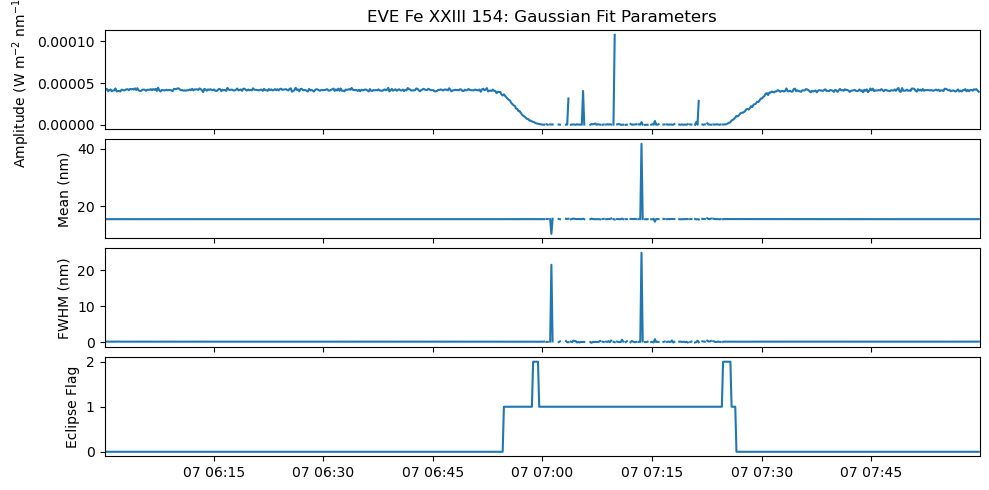

In [8]:
# create a new df containing parameters and their errors
para_err=fit_df_crop.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)

para=fit_df_crop[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

# create a df with para,para_err,time
para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df_crop['time']})
para_df.set_index('time',inplace=True)


        # 3 row 1 column    plot the parameter in 10 s cadence
fig,axs=plt.subplots(4,1,
                    figsize=(10,5),
                    sharex=True,)

convolve_length=1
amp_list=np.convolve(np.stack(para_df['para'].values)[:, 0],np.ones(convolve_length)/convolve_length,mode='same')
axs[0].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
            amp_list[convolve_length:-convolve_length],
            # s=0.003,
            # marker='x',
            )
axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

# upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
# axs[0].set_ylim(0.,1.2*upper_percentile)


mean_list=np.convolve(np.stack(para_df['para'].values)[:, 1],np.ones(convolve_length)/convolve_length,mode='same')
axs[1].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
            mean_list[convolve_length:-convolve_length],
            #    s=0.003,
            # marker='x',
            )
axs[1].set_ylabel('Mean (nm)')
# upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
# lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
# axs[1].set_ylim(lower_percentile,upper_percentile+0.01*(upper_percentile-lower_percentile))


std_list=np.convolve(np.stack(para_df['para'].values)[:, 2],np.ones(convolve_length)/convolve_length,mode='same')
axs[2].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
            gaussian_sigma_to_fwhm*std_list[convolve_length:-convolve_length],
            #    s=0.003,
            # marker='x',
            )
axs[2].set_ylabel('FWHM (nm)')
# upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
# lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
# axs[2].set_ylim(lower_percentile,upper_percentile)

axs[2].set_xlabel('Time')
# axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])

# for i in range(3):
# # add the event time and range with light orange
#     axs[i].axvline(parse_time(flares_hek['event_peaktime']).datetime,color='orange',linestyle='--',
#                     label='flare peak time')
#     axs[i].axvspan(
#         parse_time(flares_hek['event_starttime']).datetime,
#         parse_time(flares_hek['event_endtime']).datetime,
#         alpha=0.2, 
#         color='purple',
#         label=flares_hek['fl_goescls']
#     )
#     axs[i].legend(loc='upper right')

axs[3].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
            fit_df_crop['eclipse_flag'][convolve_length:-convolve_length],           
            )
axs[3].set_ylabel('Eclipse Flag')

axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Parameters')



axs[0].set_xlim(para_df.index[0],para_df.index[-1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

C:\Users\14902\AppData\Local\Temp\ipykernel_27248\3606910176.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs=plt.subplots(3,1,


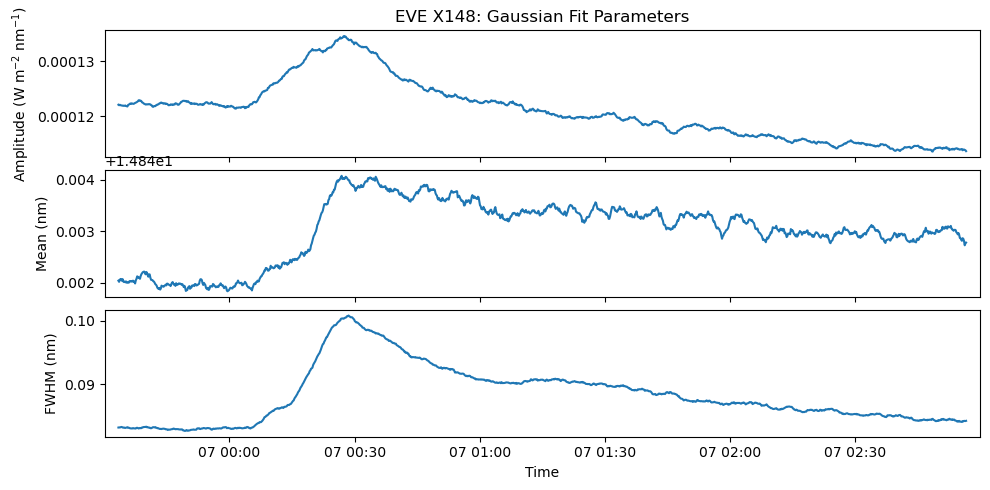

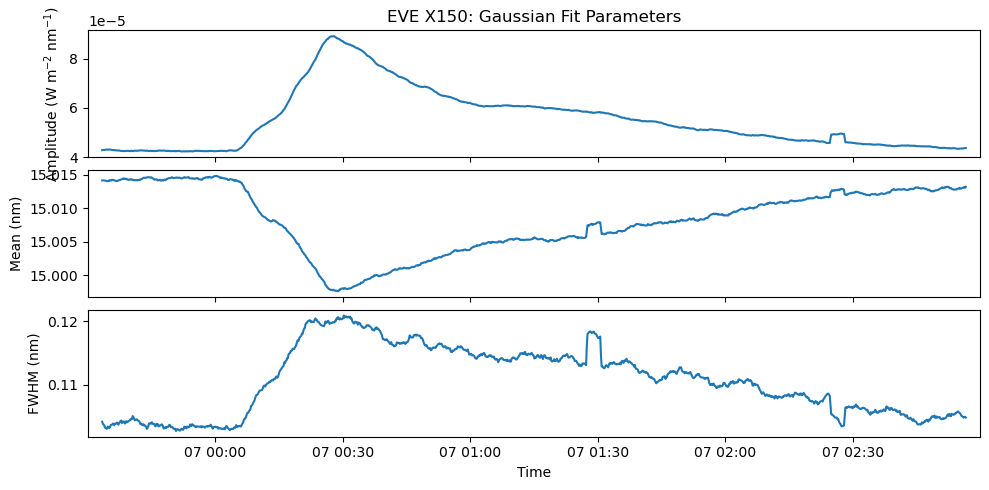

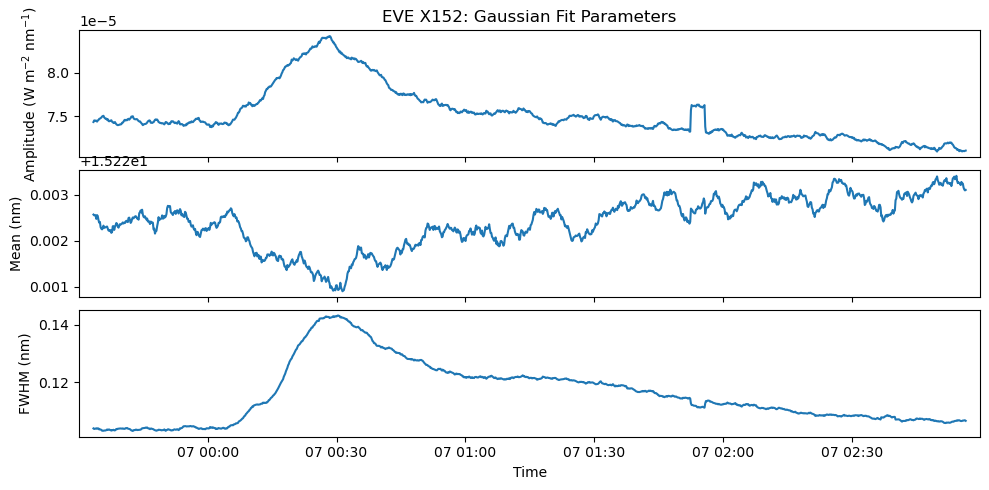

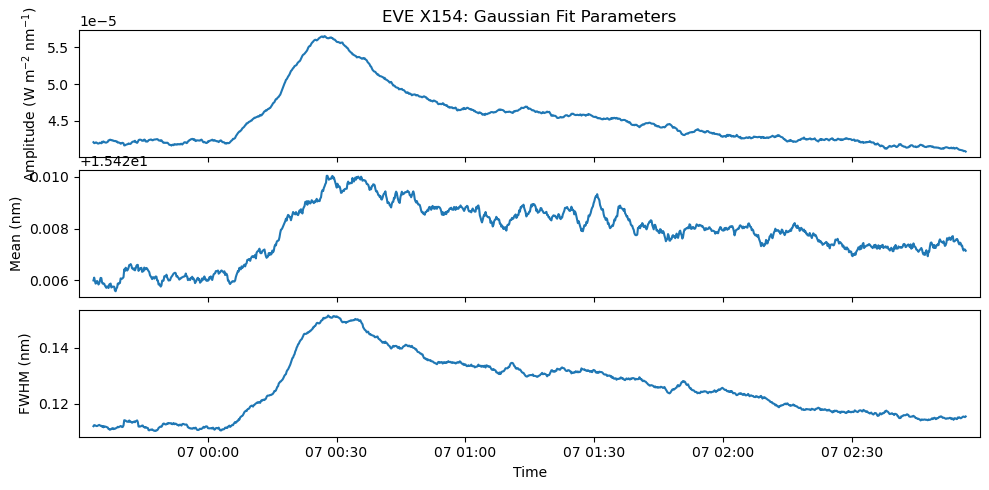

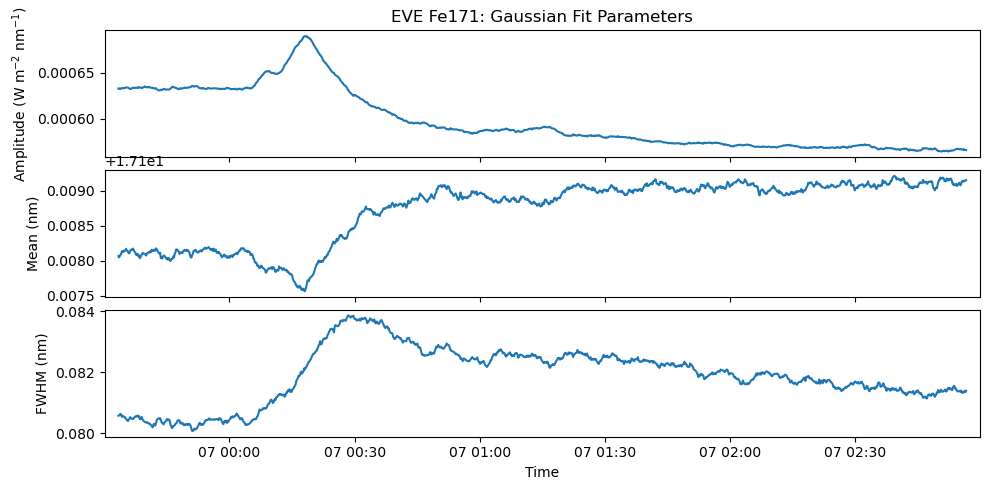

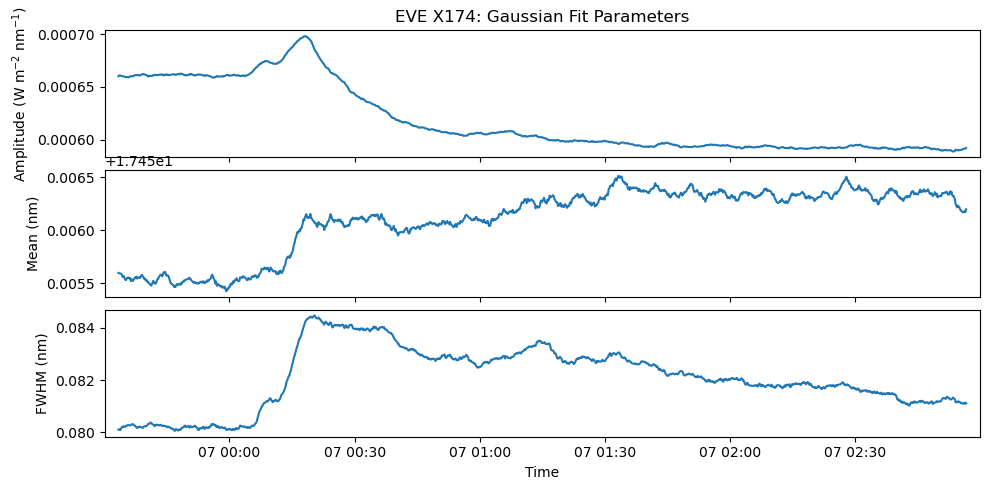

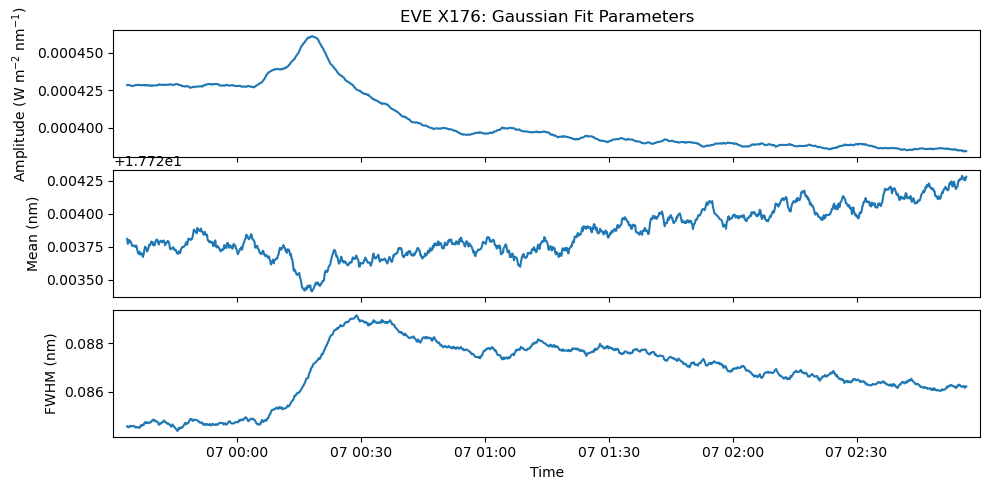

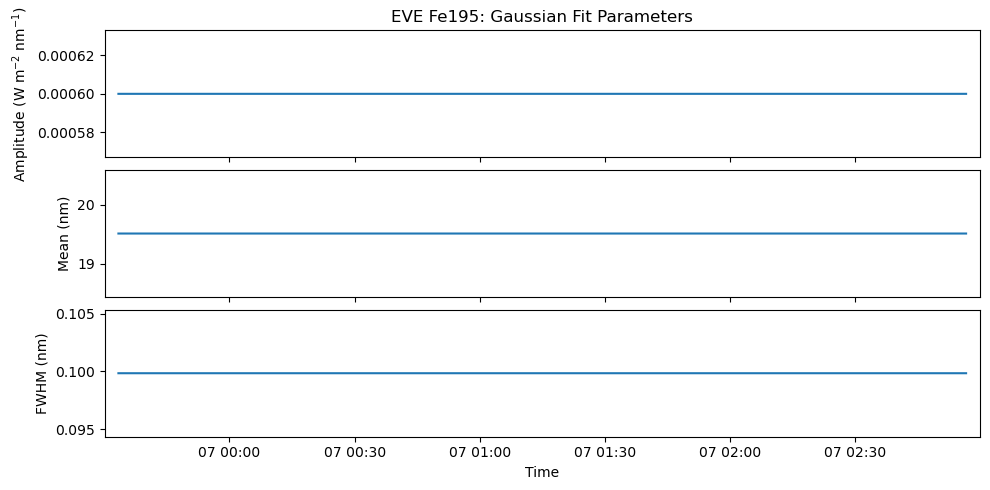

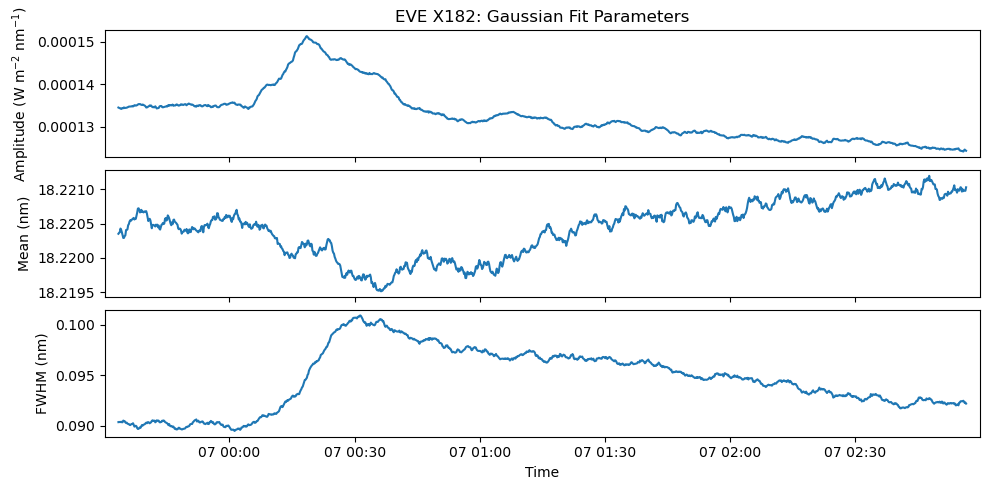

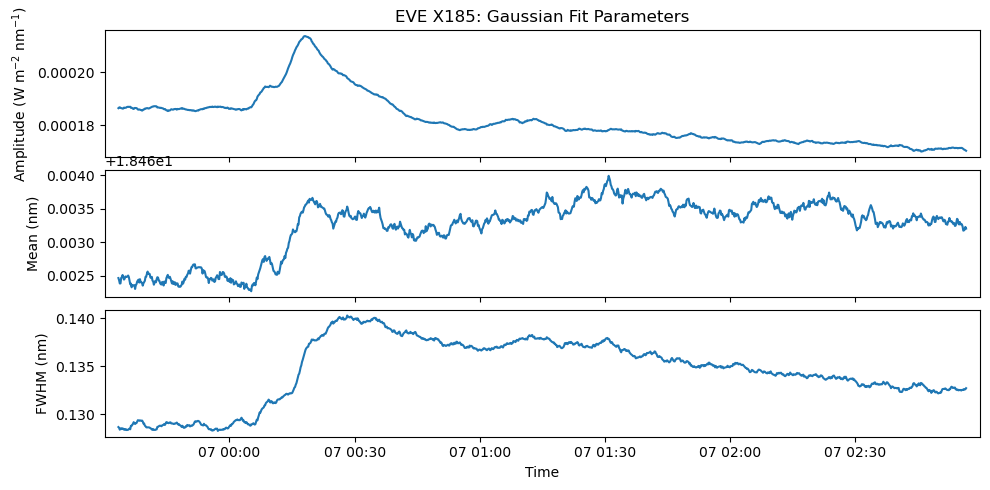

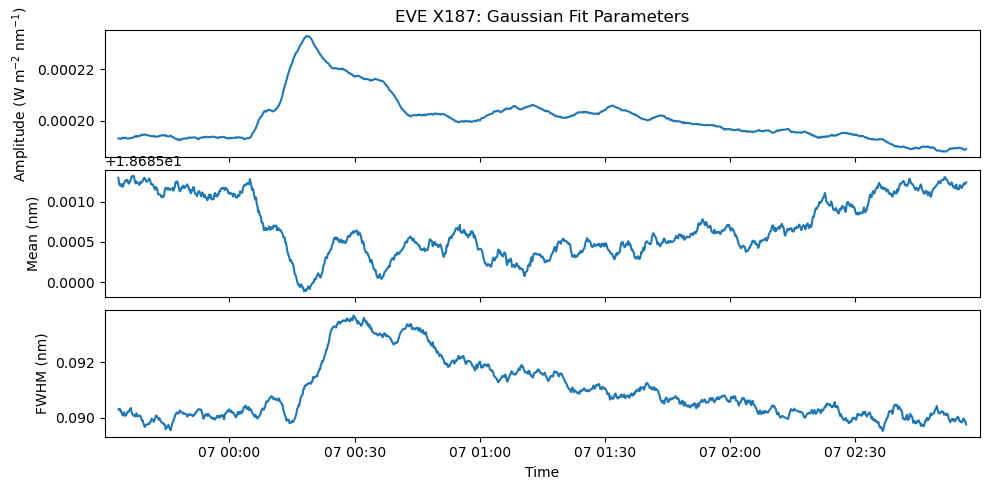

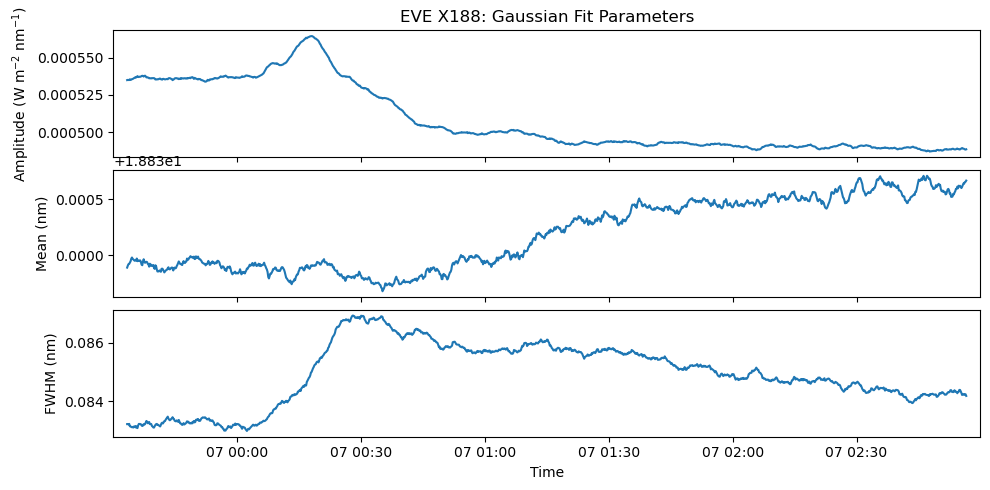

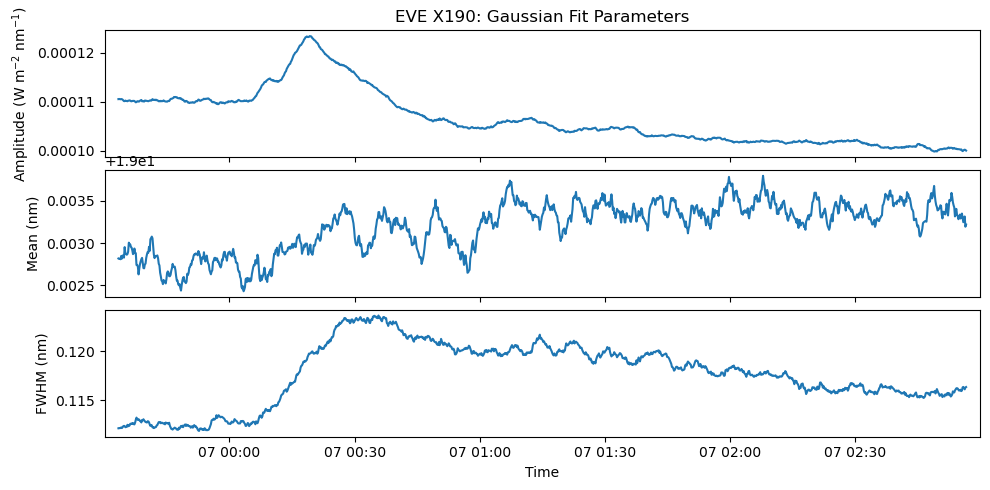

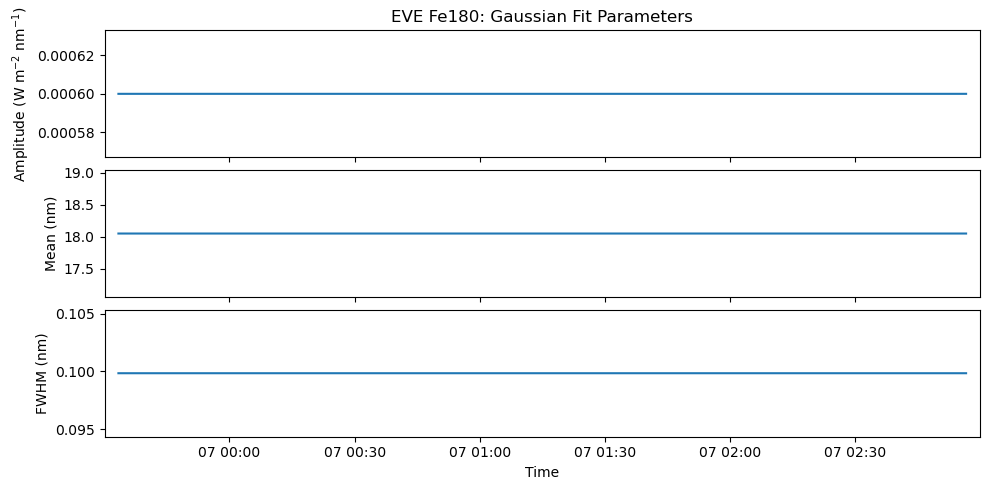

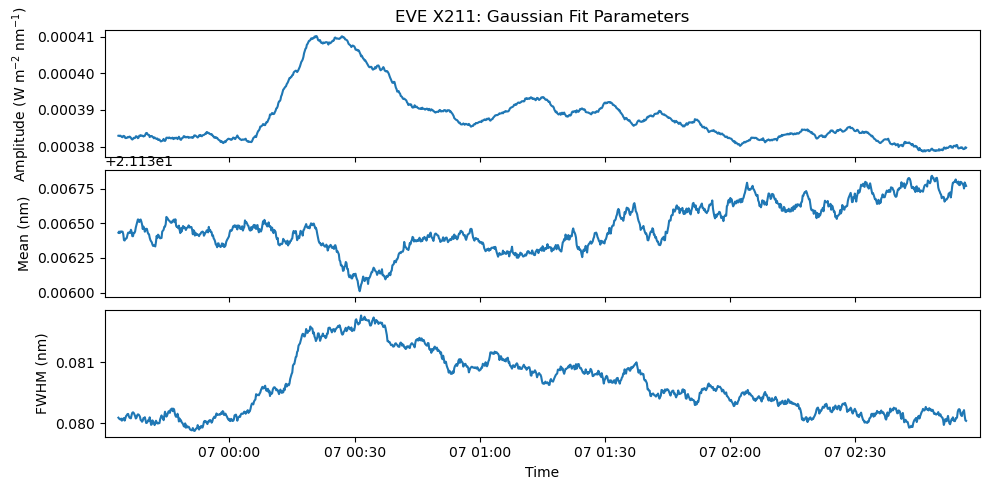

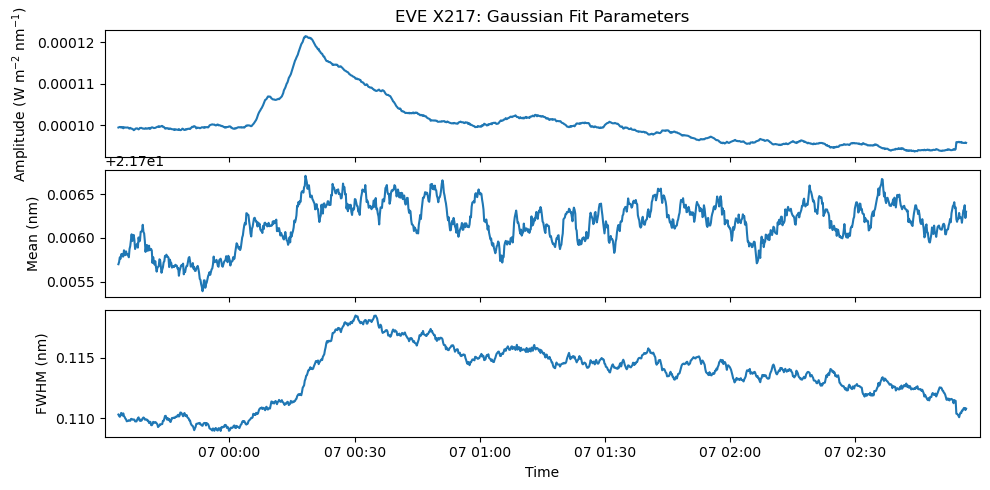

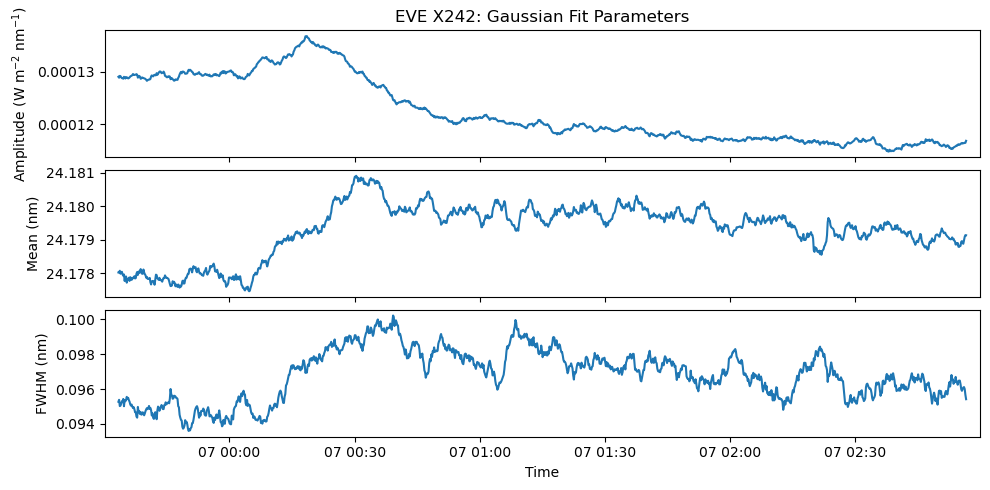

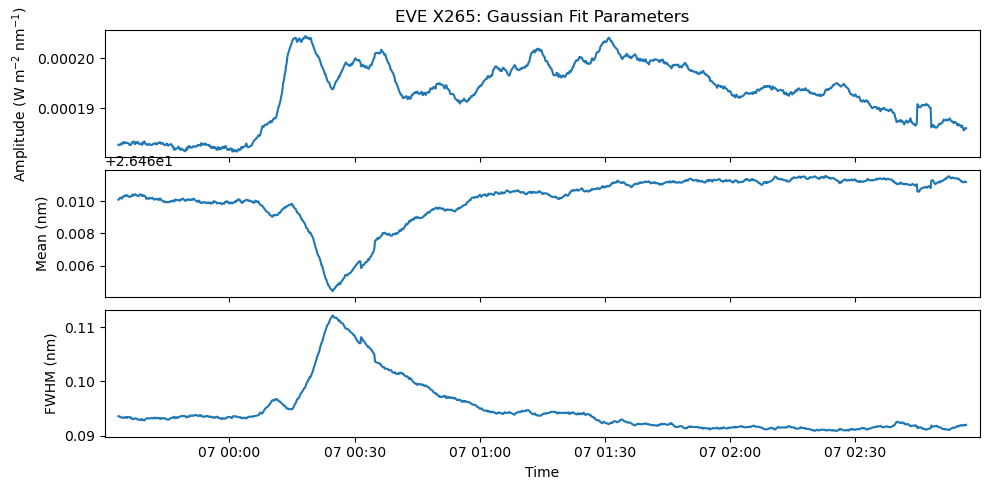

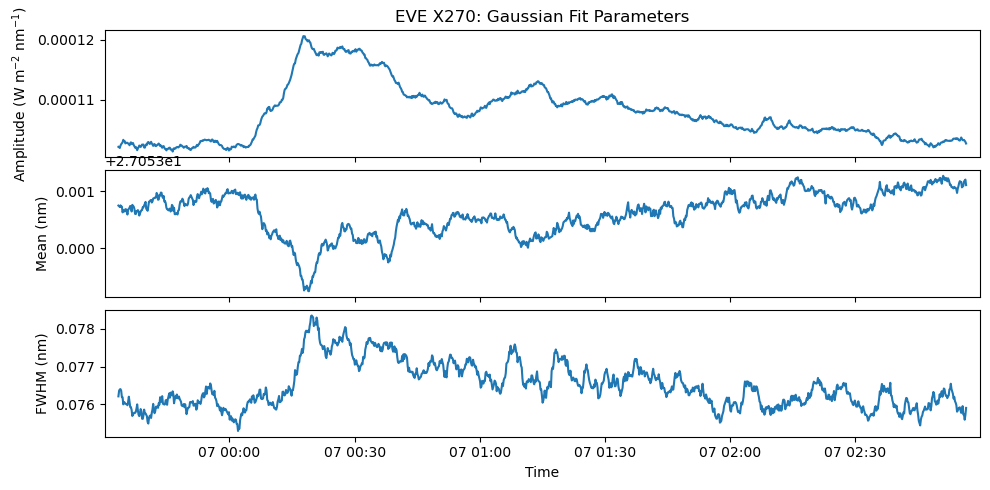

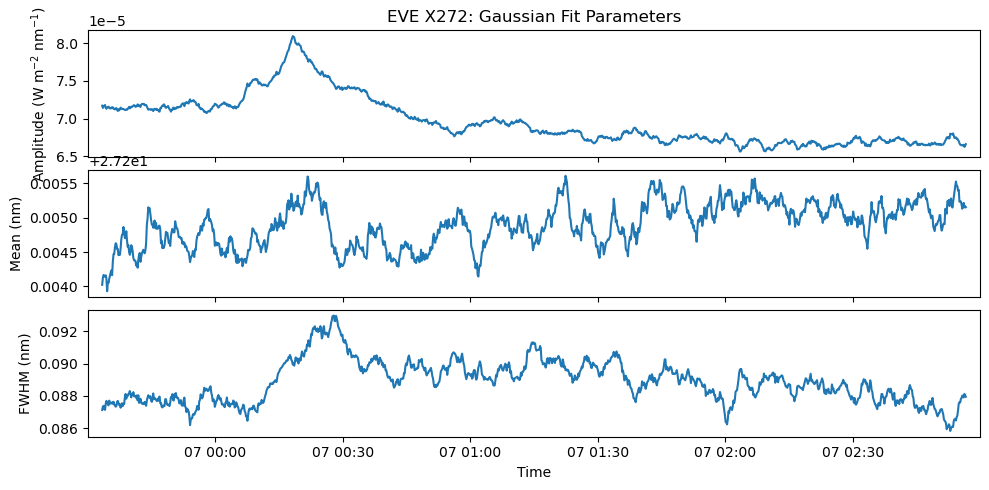

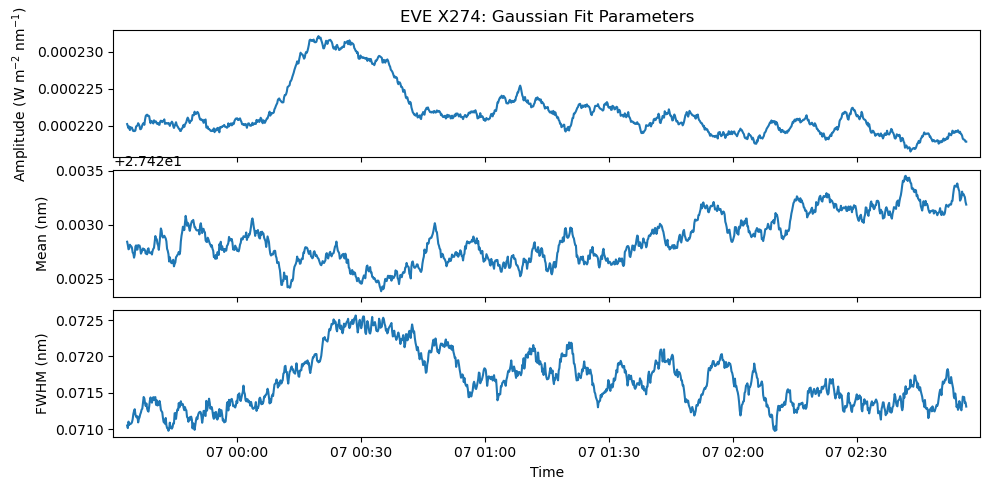

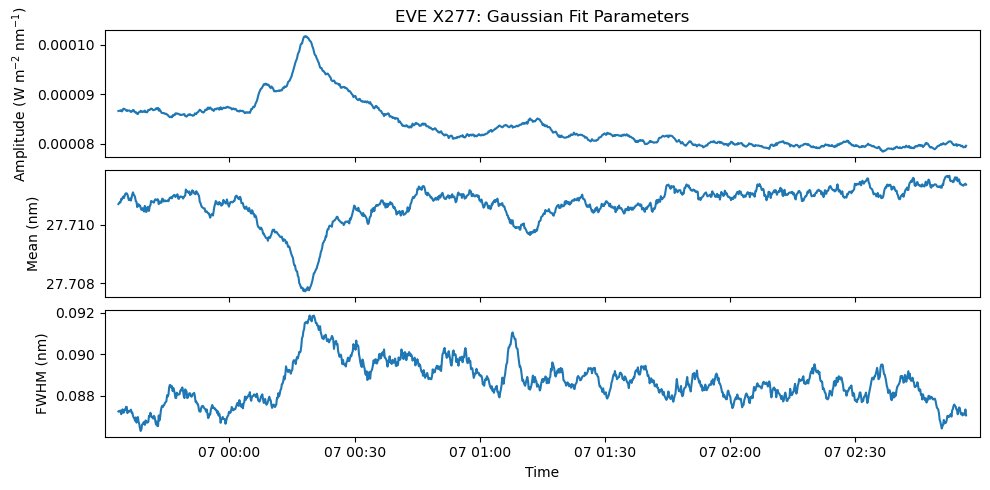

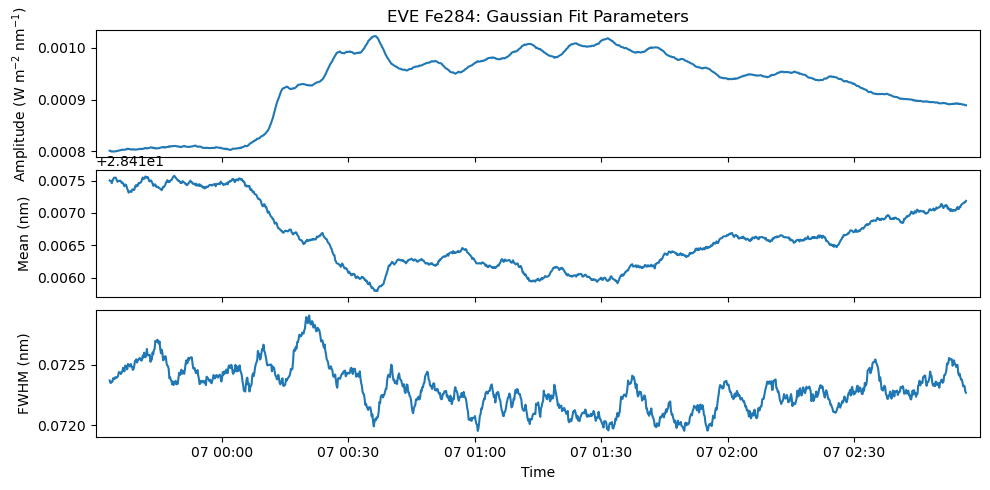

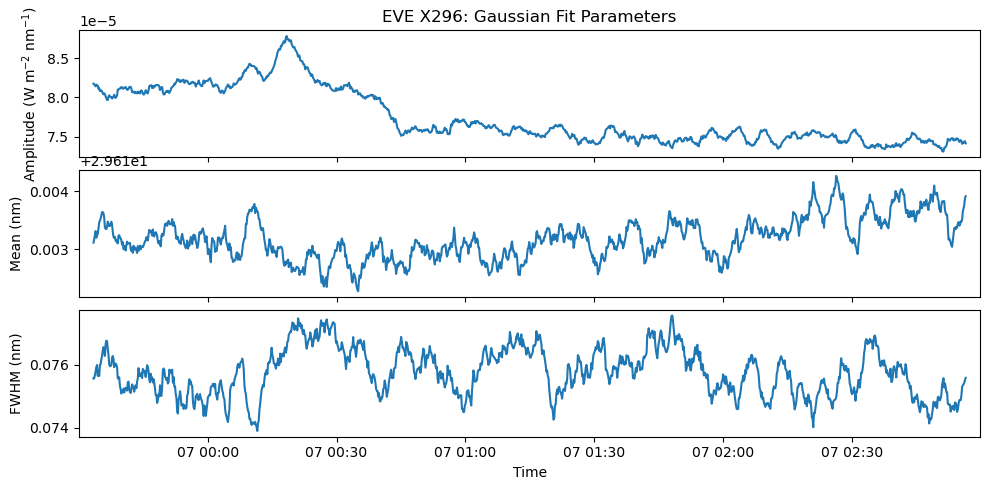

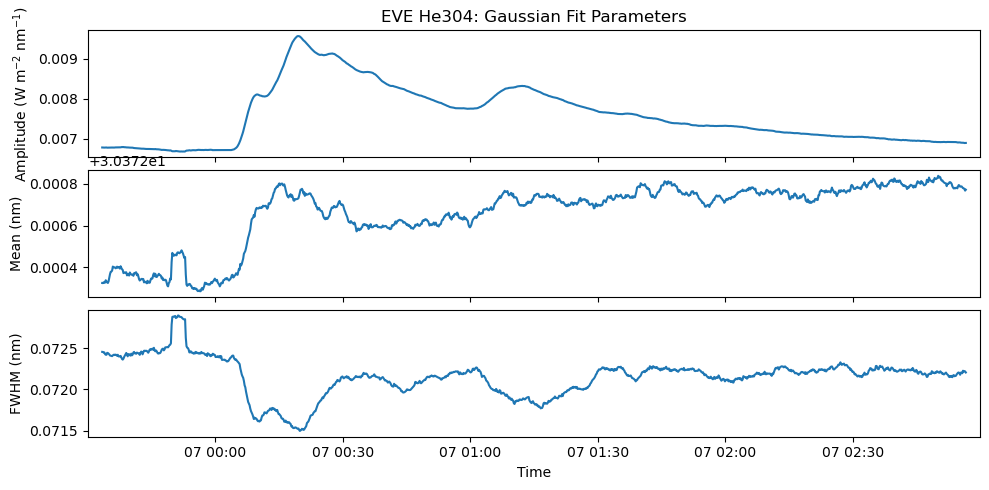

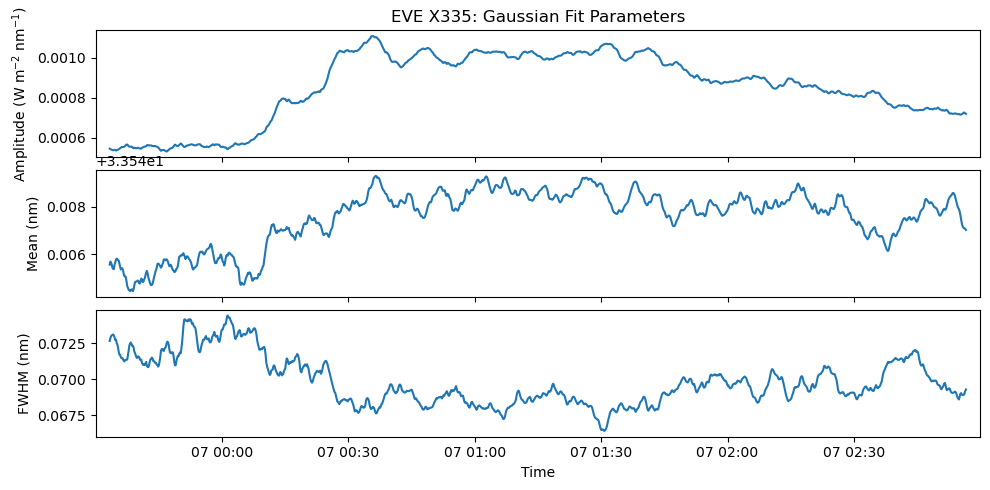

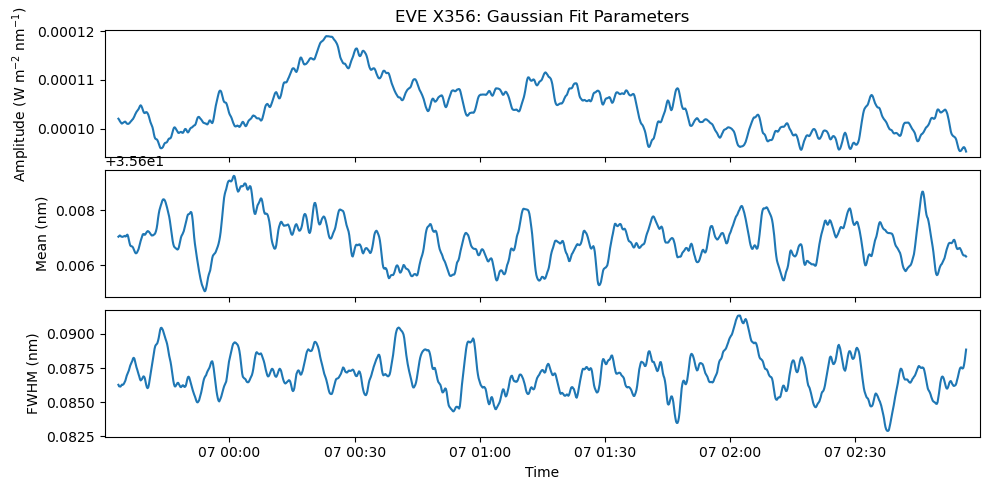

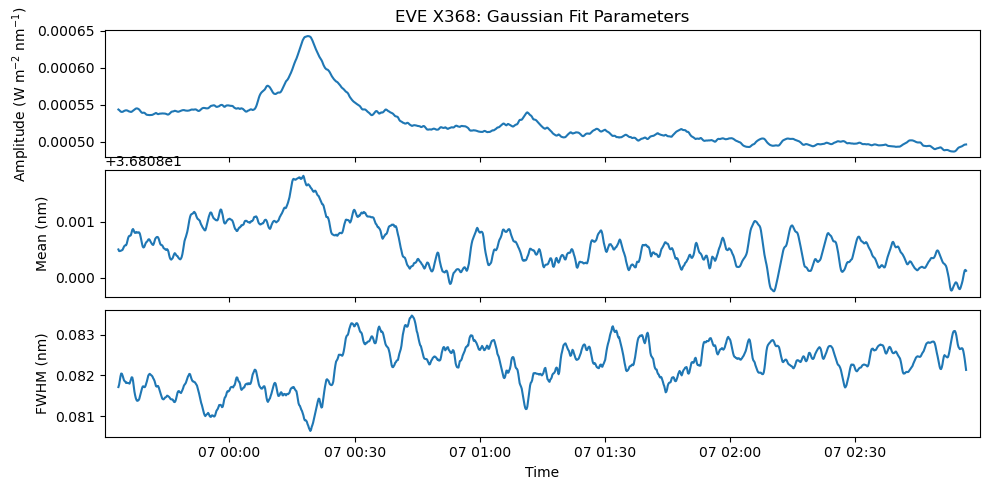

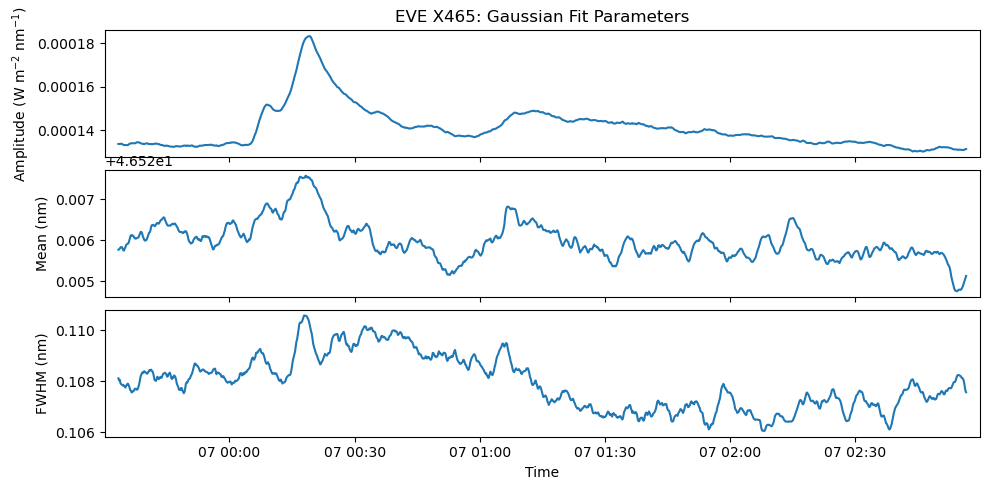

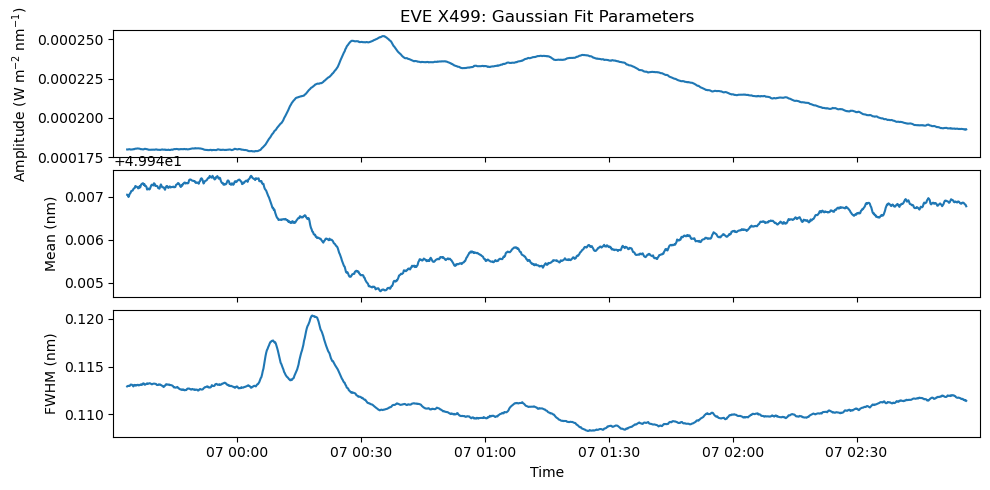

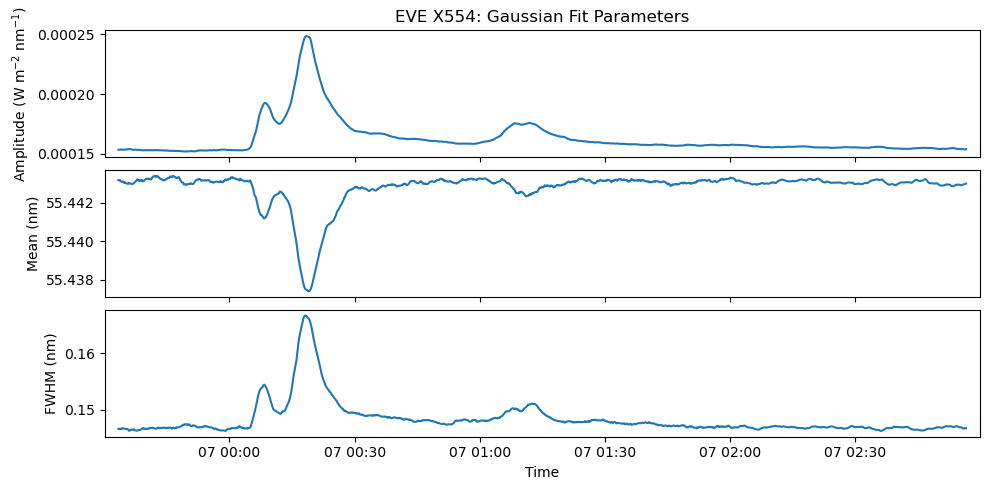

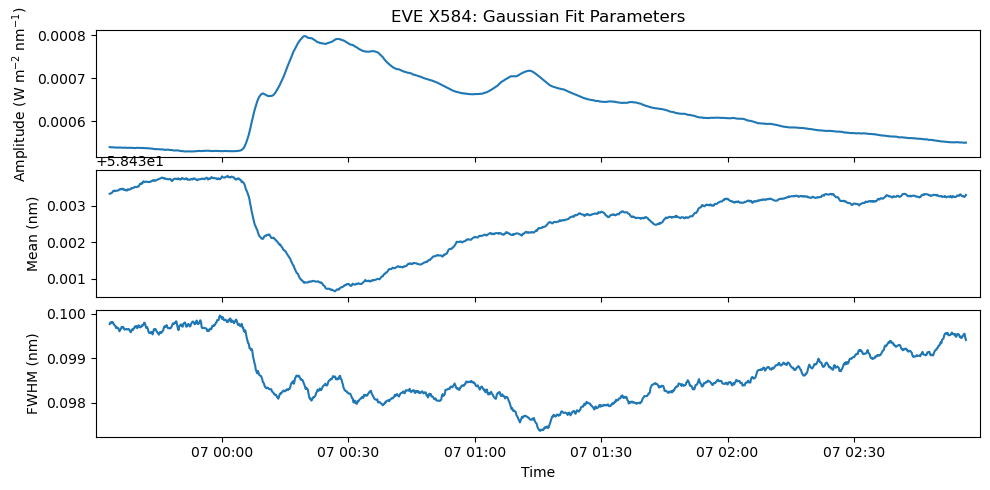

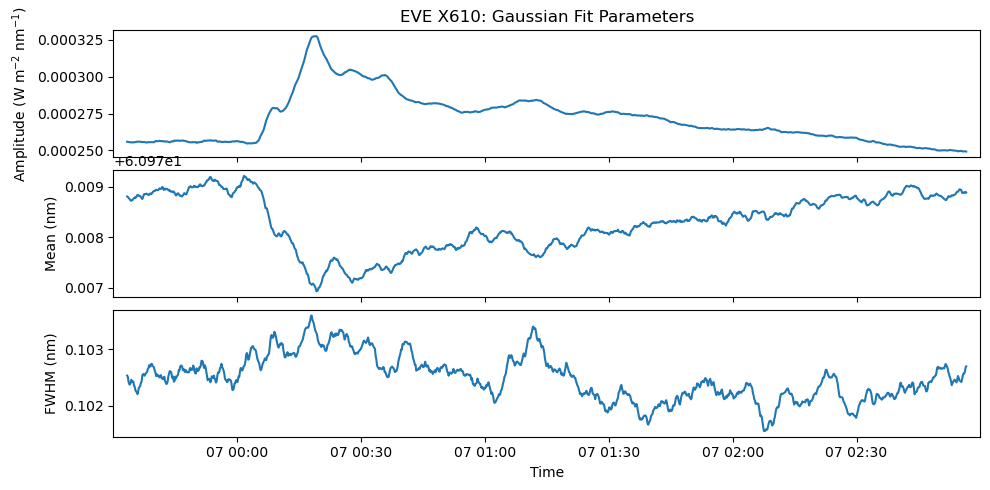

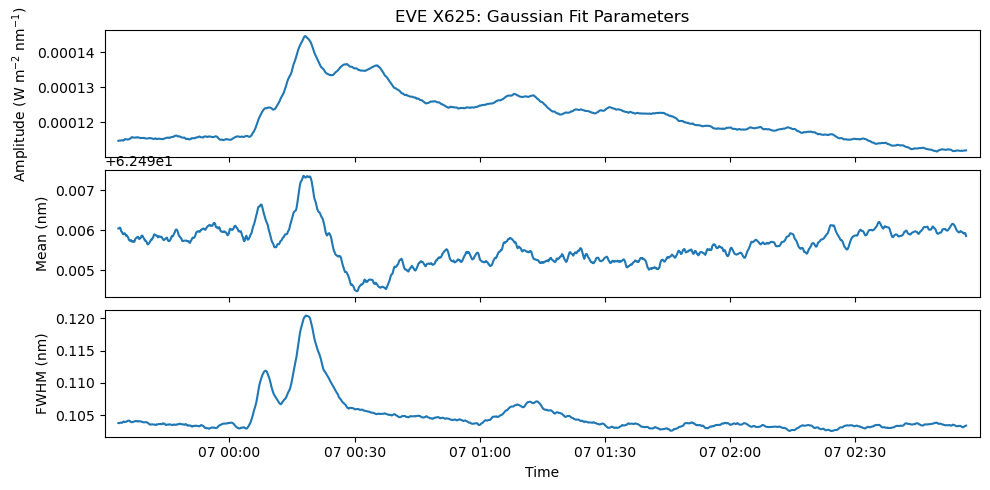

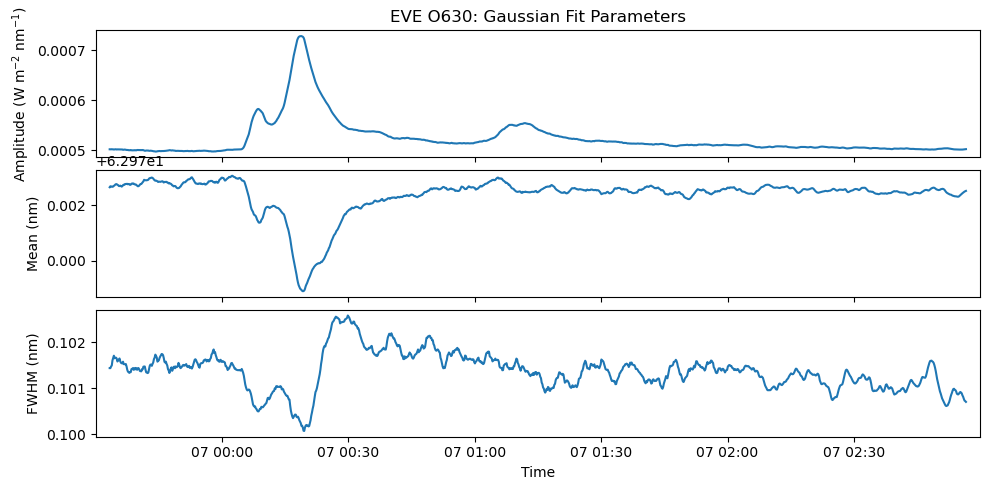

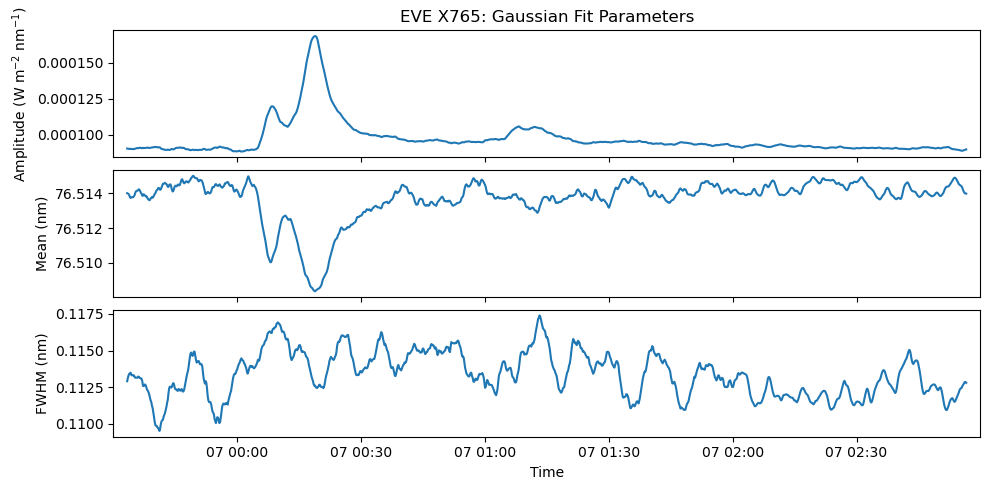

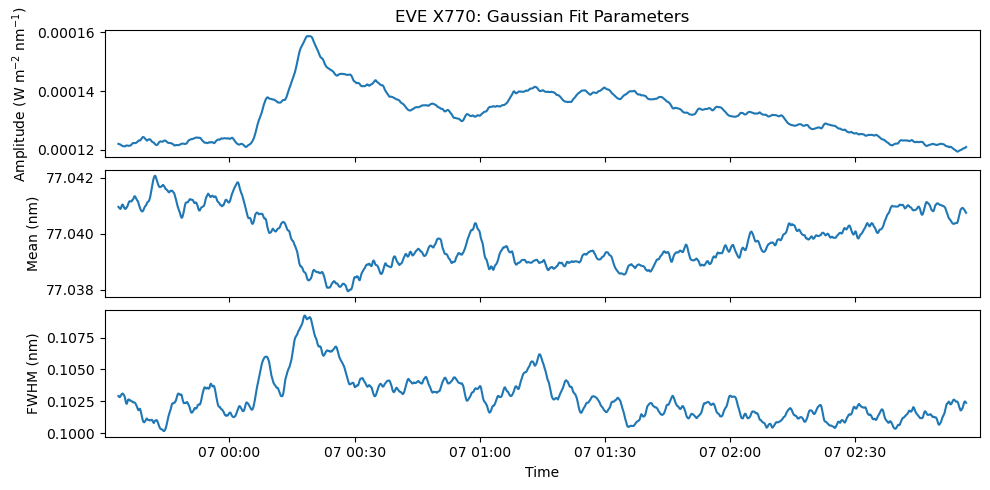

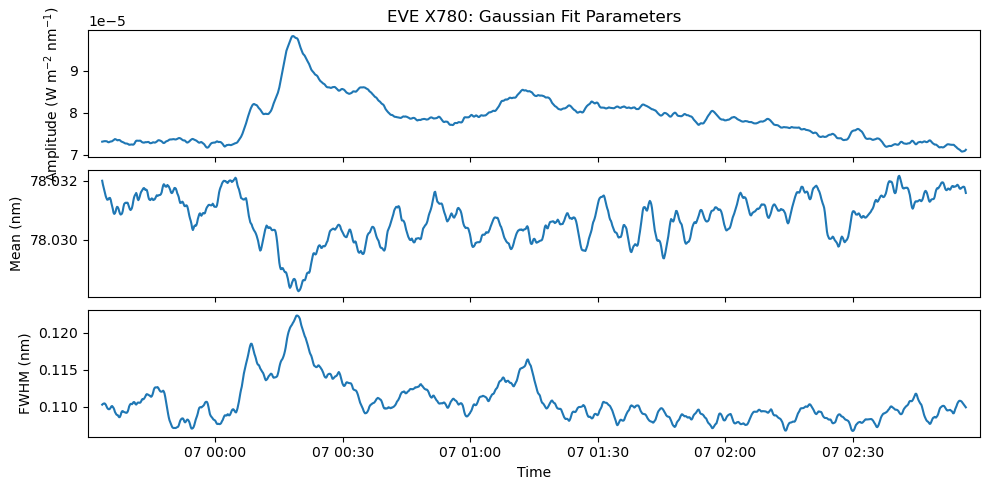

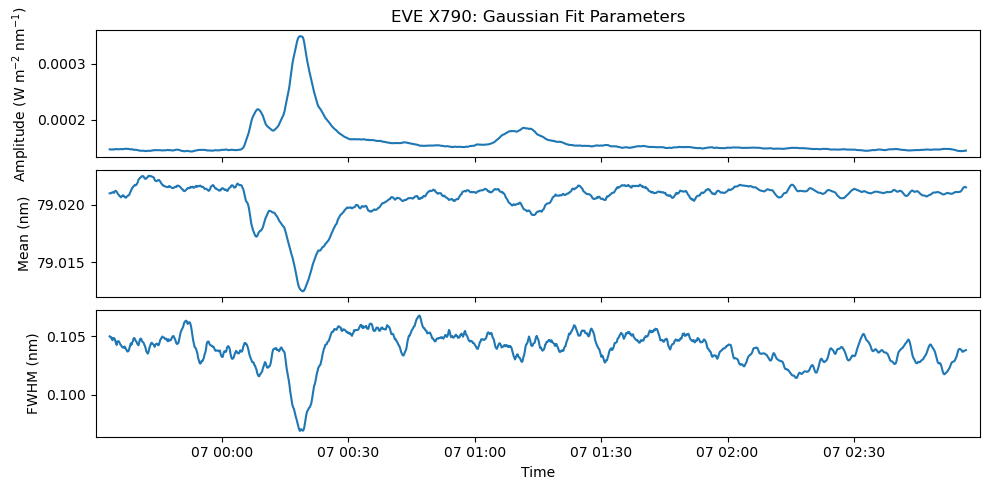

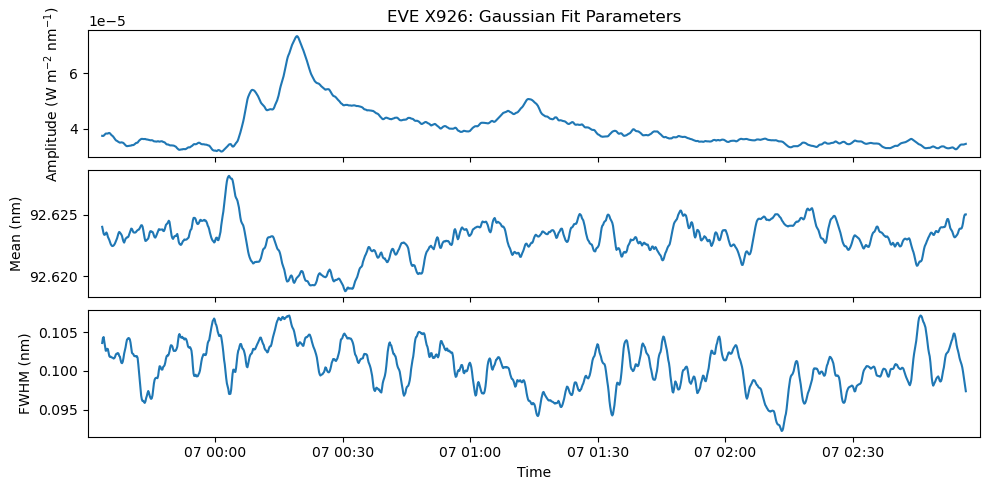

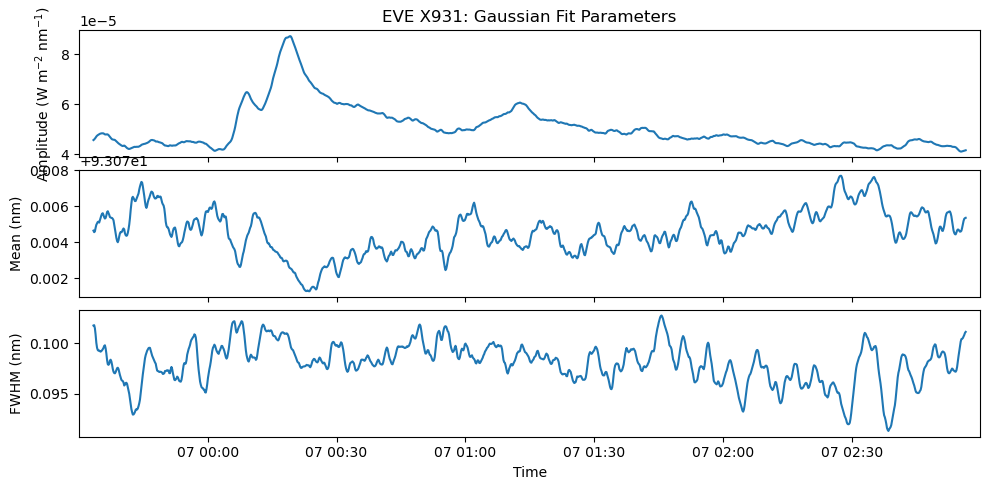

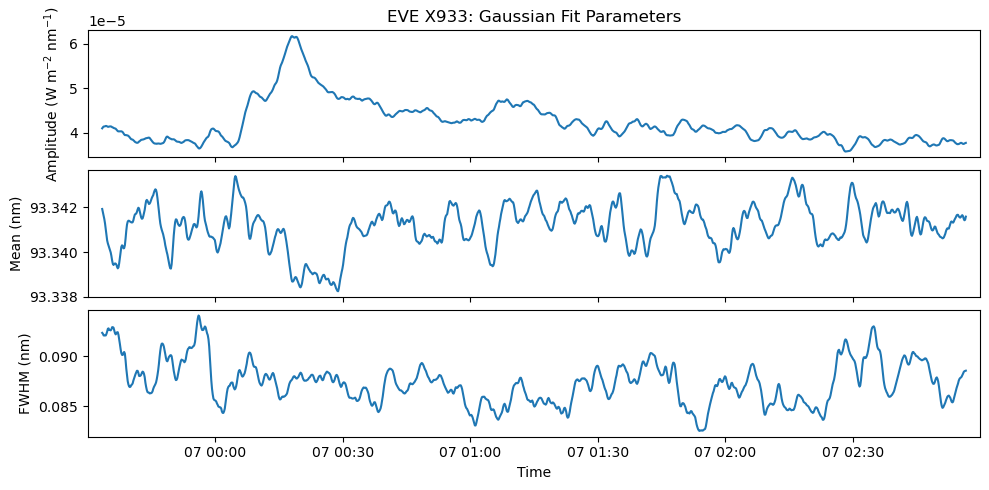

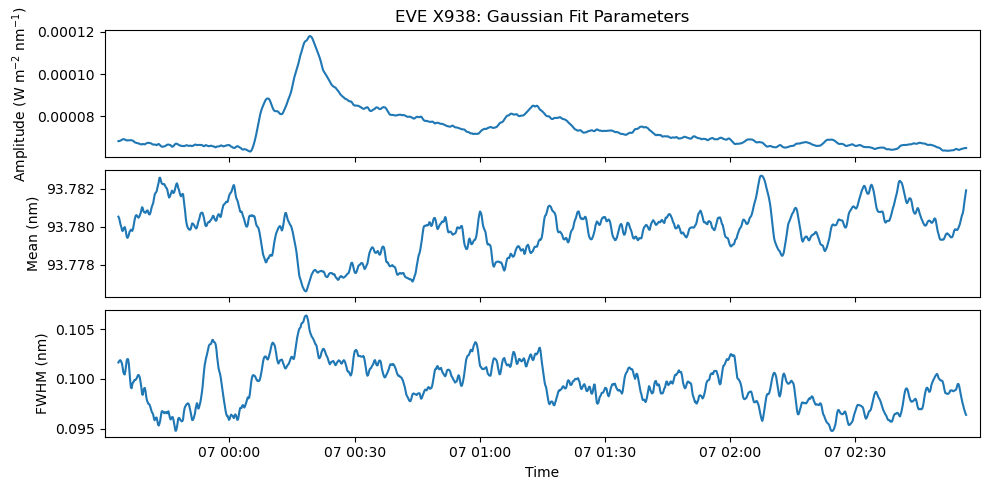

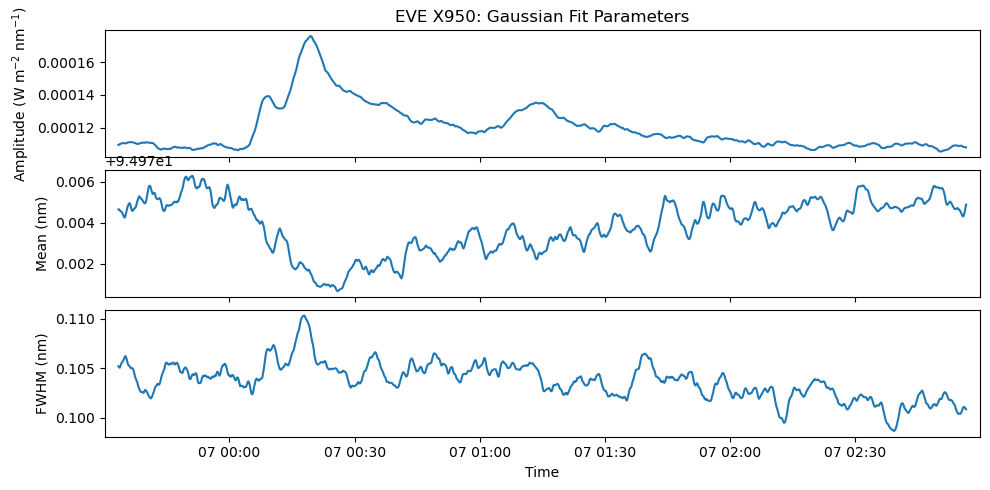

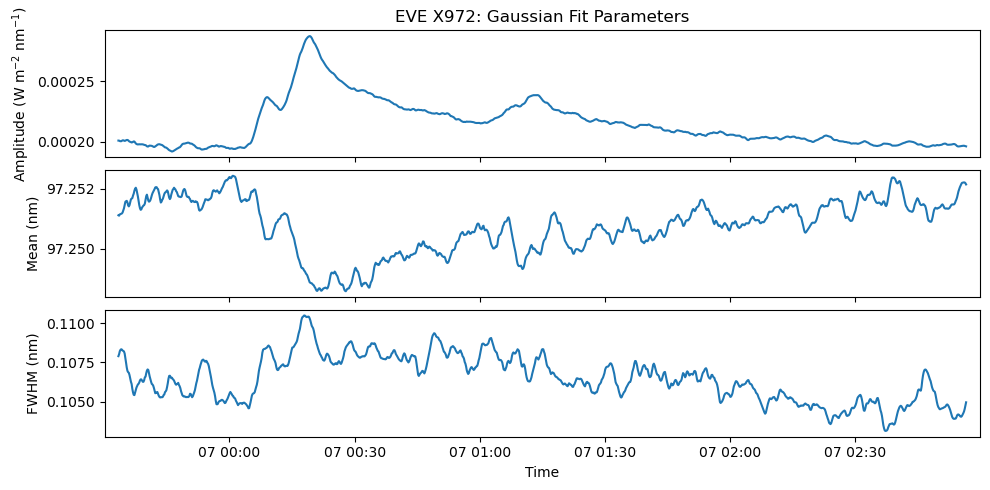

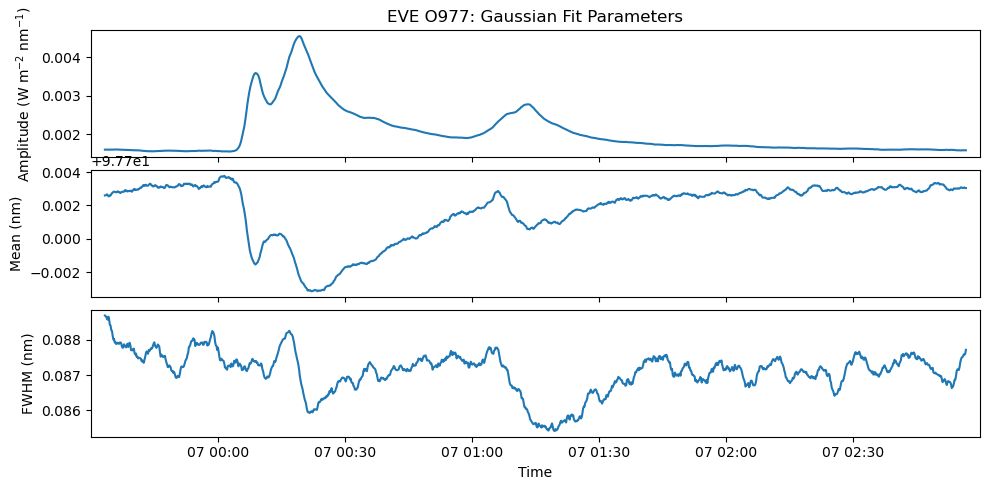

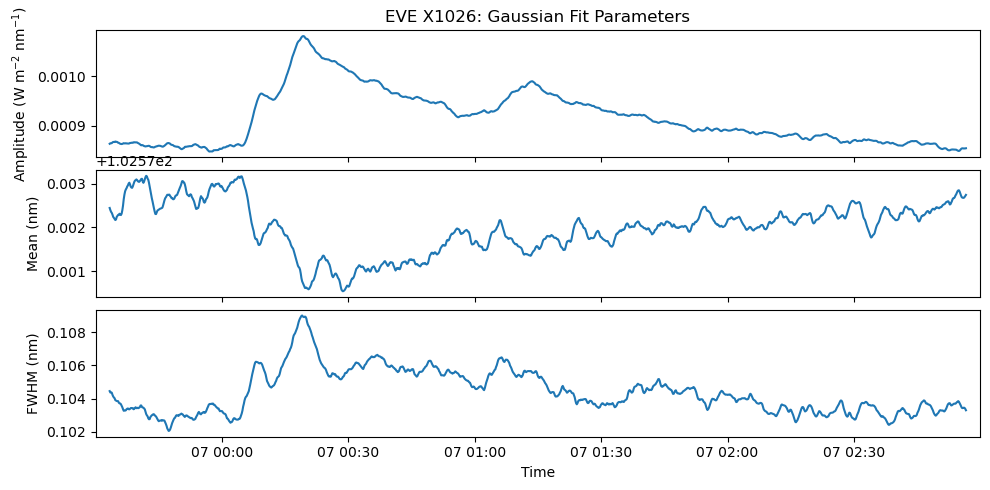

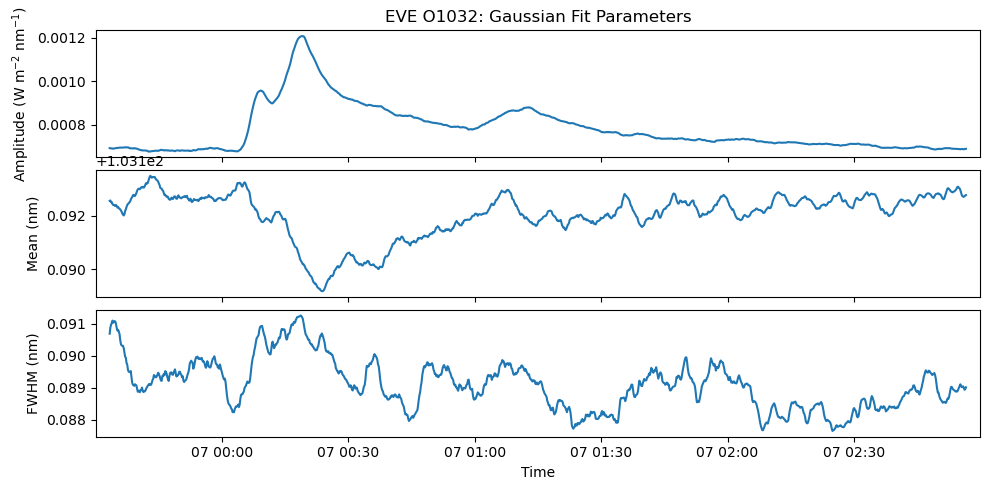

In [21]:
for index in selected_band.index[:]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df=pickle.load(file)

    fit_df_crop=fit_df[(fit_df['time']<t_end)&(fit_df['time']>t_start)]

    # create a new df containing parameters and their errors
    para_err=fit_df_crop.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)

    para=fit_df_crop[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

    # create a df with para,para_err,time
    para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df_crop['time']})
    para_df.set_index('time',inplace=True)


    # 3 row 1 column    plot the parameter in 10 s cadence
    fig,axs=plt.subplots(3,1,
                        figsize=(10,5),
                        sharex=True,)

    convolve_length=20
    amp_list=np.convolve(np.stack(para_df['para'].values)[:, 0],np.ones(convolve_length)/convolve_length,mode='same')
    axs[0].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                amp_list[convolve_length:-convolve_length],
                # s=0.003,
                # marker='x',
                )
    axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

    # upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
    # axs[0].set_ylim(0.,1.2*upper_percentile)


    mean_list=np.convolve(np.stack(para_df['para'].values)[:, 1],np.ones(convolve_length)/convolve_length,mode='same')
    axs[1].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                mean_list[convolve_length:-convolve_length],
                #    s=0.003,
                # marker='x',
                )
    axs[1].set_ylabel('Mean (nm)')
    # upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
    # lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
    # axs[1].set_ylim(lower_percentile,upper_percentile+0.01*(upper_percentile-lower_percentile))


    std_list=np.convolve(np.stack(para_df['para'].values)[:, 2],np.ones(convolve_length)/convolve_length,mode='same')
    axs[2].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                gaussian_sigma_to_fwhm*std_list[convolve_length:-convolve_length],
                #    s=0.003,
                # marker='x',
                )
    axs[2].set_ylabel('FWHM (nm)')
    # upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
    # lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
    # axs[2].set_ylim(lower_percentile,upper_percentile)

    axs[2].set_xlabel('Time')
    # axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])

    # for i in range(3):
    # # add the event time and range with light orange
    #     axs[i].axvline(parse_time(flares_hek['event_peaktime']).datetime,color='orange',linestyle='--',
    #                     label='flare peak time')
    #     axs[i].axvspan(
    #         parse_time(flares_hek['event_starttime']).datetime,
    #         parse_time(flares_hek['event_endtime']).datetime,
    #         alpha=0.2, 
    #         color='purple',
    #         label=flares_hek['fl_goescls']
    #     )
    #     axs[i].legend(loc='upper right')

    axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Parameters')



    axs[0].set_xlim(para_df.index[0],para_df.index[-1])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)

    fig.savefig('output\FirstGlance_Flare\hours\FirstGlance_Flare_'+selected_band.loc[index]['Line Name']+'.png',dpi=300)

In [73]:
result[0][1]['fl_goescls']

'C6.0'

In [23]:
t_start = parse_time(flare['event_starttime']).to_datetime()+datetime.timedelta(hours=-1)
t_end = parse_time(flare['event_endtime']).to_datetime()+datetime.timedelta(hours=+1)

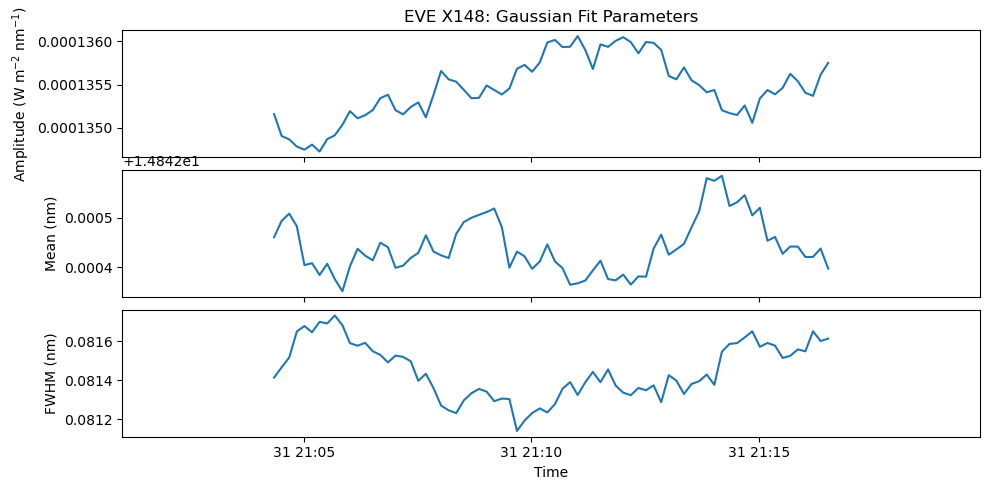

In [20]:
for index in selected_band.index[:1]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df=pickle.load(file)

    fit_df_crop=fit_df[(fit_df['time']<t_end)&(fit_df['time']>t_start)]

    # create a new df containing parameters and their errors
    para_err=fit_df_crop.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)

    para=fit_df_crop[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

    # create a df with para,para_err,time
    para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df_crop['time']})
    para_df.set_index('time',inplace=True)


    # 3 row 1 column    plot the parameter in 10 s cadence
    fig,axs=plt.subplots(3,1,
                        figsize=(10,5),
                        sharex=True,)

    convolve_length=20
    amp_list=np.convolve(np.stack(para_df['para'].values)[:, 0],np.ones(convolve_length)/convolve_length,mode='same')
    axs[0].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                amp_list[convolve_length:-convolve_length],
                # s=0.003,
                # marker='x',
                )
    axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

    # upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
    # axs[0].set_ylim(0.,1.2*upper_percentile)


    mean_list=np.convolve(np.stack(para_df['para'].values)[:, 1],np.ones(convolve_length)/convolve_length,mode='same')
    axs[1].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                mean_list[convolve_length:-convolve_length],
                #    s=0.003,
                # marker='x',
                )
    axs[1].set_ylabel('Mean (nm)')
    # upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
    # lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
    # axs[1].set_ylim(lower_percentile,upper_percentile+0.01*(upper_percentile-lower_percentile))


    std_list=np.convolve(np.stack(para_df['para'].values)[:, 2],np.ones(convolve_length)/convolve_length,mode='same')
    axs[2].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                gaussian_sigma_to_fwhm*std_list[convolve_length:-convolve_length],
                #    s=0.003,
                # marker='x',
                )
    axs[2].set_ylabel('FWHM (nm)')
    # upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
    # lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
    # axs[2].set_ylim(lower_percentile,upper_percentile)

    axs[2].set_xlabel('Time')
    # axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])


    # for i in range(3):
    # # add the event time and range with light orange
    #     axs[i].axvline(parse_time(flares_hek['event_peaktime']).datetime,color='orange',linestyle='--',
    #                     label='flare peak time')
    #     axs[i].axvspan(
    #         parse_time(flares_hek['event_starttime']).datetime,
    #         parse_time(flares_hek['event_endtime']).datetime,
    #         alpha=0.2, 
    #         color='purple',
    #         label=flares_hek['fl_goescls']
    #     )
    #     axs[i].legend(loc='upper right')

    axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Parameters')



    axs[0].set_xlim(para_df.index[0],para_df.index[-1])

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)

    # fig.savefig('output\FirstGlance_Flare\hours\FirstGlance_Flare_'+selected_band.loc[index]['Line Name']+'.png',dpi=300)

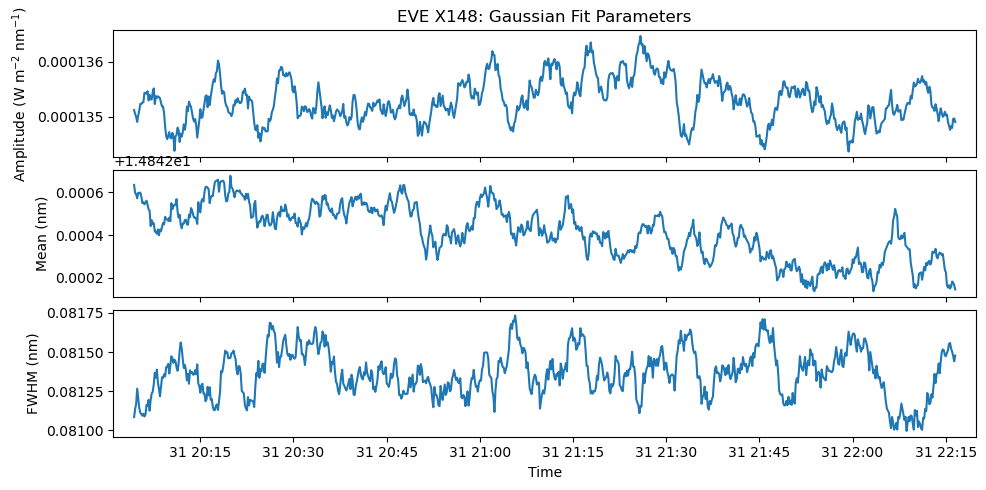

In [26]:
fit_df_crop=fit_df[(fit_df['time']<t_end)&(fit_df['time']>t_start)]

# create a new df containing parameters and their errors
para_err=fit_df_crop.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)

para=fit_df_crop[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

# create a df with para,para_err,time
para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df_crop['time']})
para_df.set_index('time',inplace=True)


# 3 row 1 column    plot the parameter in 10 s cadence
fig,axs=plt.subplots(3,1,
                    figsize=(10,5),
                    sharex=True,)

convolve_length=20
amp_list=np.convolve(np.stack(para_df['para'].values)[:, 0],np.ones(convolve_length)/convolve_length,mode='same')
axs[0].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
            amp_list[convolve_length:-convolve_length],
            # s=0.003,
            # marker='x',
            )
axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

# upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
# axs[0].set_ylim(0.,1.2*upper_percentile)


mean_list=np.convolve(np.stack(para_df['para'].values)[:, 1],np.ones(convolve_length)/convolve_length,mode='same')
axs[1].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
            mean_list[convolve_length:-convolve_length],
            #    s=0.003,
            # marker='x',
            )
axs[1].set_ylabel('Mean (nm)')
# upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
# lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
# axs[1].set_ylim(lower_percentile,upper_percentile+0.01*(upper_percentile-lower_percentile))


std_list=np.convolve(np.stack(para_df['para'].values)[:, 2],np.ones(convolve_length)/convolve_length,mode='same')
axs[2].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
            gaussian_sigma_to_fwhm*std_list[convolve_length:-convolve_length],
            #    s=0.003,
            # marker='x',
            )
axs[2].set_ylabel('FWHM (nm)')
# upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
# lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
# axs[2].set_ylim(lower_percentile,upper_percentile)

axs[2].set_xlabel('Time')
# axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])


# for i in range(3):
# # add the event time and range with light orange
#     axs[i].axvline(parse_time(flares_hek['event_peaktime']).datetime,color='orange',linestyle='--',
#                     label='flare peak time')
#     axs[i].axvspan(
#         parse_time(flares_hek['event_starttime']).datetime,
#         parse_time(flares_hek['event_endtime']).datetime,
#         alpha=0.2, 
#         color='purple',
#         label=flares_hek['fl_goescls']
#     )
#     axs[i].legend(loc='upper right')

axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Parameters')



axs[0].set_xlim(para_df.index[0],para_df.index[-1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
# close fig
# plt.close(fig)



# fig.savefig('output\FirstGlance_Flare\hours\FirstGlance_Flare_'+selected_band.loc[index]['Line Name']+'.png',dpi=300)

# Flare Plot

## download flare info from hek

In [1]:
tstart = "2011-03-01T00:00:00" 
tend = "2013-06-01T00:00:00"

tr=a.Time(tstart, tend)
result=Fido.search(tr,(a.hek.EventType('FL') ) & (a.hek.FRM.Name == 'SWPC'))

NameError: name 'a' is not defined

In [ ]:
# save the variable result into a pkl file
with open('data/flare_hek.pkl','wb') as f:
    pickle.dump(result,f)

In [3]:
with open('data/flare_hek.pkl','rb') as f:
    result=pickle.load(f)

## select some flare, and crop the df
only the x class flare

In [75]:
# create a folder named flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d') to store the plots
# if the folder already exists, skip the creation
# if not, create the folder
flare_list=[]


for flare in result[0]:
    if flare['fl_goescls'][0] == 'X':
        flare_list.append(flare)
        print(flare['fl_goescls'],flare['event_starttime'],flare['event_endtime'])


        folder_name=flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H%M%S')
        if not os.path.exists('output\FirstGlance_Flare\\'+folder_name):
            os.makedirs('output\FirstGlance_Flare\\'+folder_name)

X1.5 2011-03-09 23:13:00.000 2011-03-09 23:29:00.000
X6.9 2011-08-09 07:48:00.000 2011-08-09 08:08:00.000
X2.1 2011-09-06 22:12:00.000 2011-09-06 22:24:00.000
X1.8 2011-09-07 22:32:00.000 2011-09-07 22:44:00.000
X1.4 2011-09-22 10:29:00.000 2011-09-22 11:44:00.000
X1.9 2011-09-24 09:21:00.000 2011-09-24 09:48:00.000
X1.9 2011-11-03 20:16:00.000 2011-11-03 20:32:00.000
X1.7 2012-01-27 17:37:00.000 2012-01-27 18:56:00.000
X1.1 2012-03-05 02:30:00.000 2012-03-05 04:43:00.000
X5.4 2012-03-07 00:02:00.000 2012-03-07 00:40:00.000
X1.3 2012-03-07 01:05:00.000 2012-03-07 01:23:00.000
X1.1 2012-07-06 23:01:00.000 2012-07-06 23:14:00.000
X1.4 2012-07-12 15:37:00.000 2012-07-12 17:30:00.000
X1.8 2012-10-23 03:13:00.000 2012-10-23 03:21:00.000
X1.7 2013-05-13 01:53:00.000 2013-05-13 02:32:00.000
X2.8 2013-05-13 15:48:00.000 2013-05-13 16:16:00.000
X3.2 2013-05-14 00:00:00.000 2013-05-14 01:20:00.000
X1.2 2013-05-15 01:25:00.000 2013-05-15 01:58:00.000


In [131]:
# create a df. cols: event_time: peak time of the flare
#                     wavelength: wavelength of the line
#                     time: time of the observation, an 1D array
#                     amplitude: amplitude of the line, an 1D array
#                     mean: mean of the line, an 1D array
#                     stddev: stddev of the line, an 1D array

# one spectrum of one flare is one row

df={'t_start':[],'t_end':[],'t_peak':[],'Line Name':[],
    'time':[],'amplitude':[],'mean':[],'stddev':[]}


In [149]:
flare_list.__len__()

18

In [146]:
df={'t_start':[],'t_end':[],'t_peak':[],'Line Name':[],
    'time':[],'amplitude':[],'mean':[],'stddev':[]}

for index in selected_band.index[:]:
    with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
        fit_df=pickle.load(file)

    for flare in flare_list[:]:
        t_start = parse_time(flare['event_starttime']).to_datetime()+datetime.timedelta(hours=-1)
        t_end = parse_time(flare['event_endtime']).to_datetime()+datetime.timedelta(hours=+1)
        t_peak = parse_time(flare['event_peaktime']).to_datetime()
        folder_name=flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H%M%S')
        fit_df_crop=fit_df[(fit_df['time']<t_end)&(fit_df['time']>t_start)]

        df['t_start'].append(t_start)
        df['t_end'].append(t_end)
        df['t_peak'].append(t_peak)
        df['Line Name'].append(selected_band.loc[index]['Line Name'])
        df['time'].append(fit_df_crop['time'])
        df['amplitude'].append(fit_df_crop['amplitude'].values)
        df['mean'].append(fit_df_crop['mean'].values)
        df['stddev'].append(fit_df_crop['stddev'].values)

In [159]:
df=pd.DataFrame(df)

# save the df into a pkl file
with open('data/flare_obs.pkl','wb') as f:
    pickle.dump(df,f)
    pickle.dump(flare_list,f)

## complete all prep

In [4]:
with open('data/flare_obs.pkl','rb') as f:
    flare_obs_df=pickle.load(f)
    flare_list=pickle.load(f)

## Each Flare

In [233]:
# one flare in one folder
for index in selected_band.index[:]:
    for flare in flare_list[:]:
        folder_name=flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H%M%S')
        
        one_flare_df=flare_obs_df[flare_obs_df['t_peak']==flare['event_peaktime'].to_datetime()]
        one_flare_df=one_flare_df[one_flare_df['Line Name']==selected_band.loc[index]['Line Name']]

        fig,axs=plt.subplots(3,1,                    figsize=(10,5),                    sharex=True,)

        convolve_length=10
        amp_list=np.convolve( one_flare_df['amplitude'].values[0],np.ones(convolve_length)/convolve_length,mode='same')
        time_list=pd.DatetimeIndex(one_flare_df['time'].values[0])
        axs[0].plot(time_list[convolve_length:-convolve_length],  #  fit_df_crop['time'][convolve_length:-convolve_length].to_pydatetime(),
                    amp_list[convolve_length:-convolve_length],                          )
        axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')
        

        mean_list=np.convolve(one_flare_df['mean'].values[0],np.ones(convolve_length)/convolve_length,mode='same')
        axs[1].plot(time_list[convolve_length:-convolve_length],
                    mean_list[convolve_length:-convolve_length],                    )
        axs[1].set_ylabel('Mean (nm)')
        
        stddev_list=np.convolve(one_flare_df['stddev'].values[0],np.ones(convolve_length)/convolve_length,mode='same')
        axs[2].plot(time_list[convolve_length:-convolve_length],
                    gaussian_sigma_to_fwhm*stddev_list[convolve_length:-convolve_length],                    )
        axs[2].set_ylabel('FWHM (nm)')
        
        axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Parameters       '+flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H:%M:%S'))
        axs[0].set_xlim(min(time_list),max(time_list))



        for i in range(3):
        # add the event time and range with light orange
            axs[i].axvline(parse_time(flare['event_peaktime']).datetime,color='orange',linestyle='--',
                            label='flare peak time')
            axs[i].axvspan(
                parse_time(flare['event_starttime']).datetime,
                parse_time(flare['event_endtime']).datetime,
                alpha=0.2, 
                color='purple',
                label=flare['fl_goescls']
            )
            axs[i].legend(loc='upper right')


        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1)
        plt.close(fig)
        fig.savefig('output\FirstGlance_Flare\\'+folder_name+'\FirstGlance_Flare_'+selected_band.loc[index]['Line Name']+'.png',dpi=300)
        


In [235]:
for index in selected_band.index[:]:
    folder_name=selected_band.loc[index]['Line Name']
    if not os.path.exists('output\FirstGlance_Flare\\sort_by_spectrum\\'+folder_name):
        os.makedirs('output\FirstGlance_Flare\\sort_by_spectrum\\'+folder_name)

## Each spectrum

In [244]:
# one spectrum in one folder
for index in selected_band.index[:]:
    for flare in flare_list[:]:
        folder_name=flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H%M%S')
        
        one_flare_df=flare_obs_df[flare_obs_df['t_peak']==flare['event_peaktime'].to_datetime()]
        one_flare_df=one_flare_df[one_flare_df['Line Name']==selected_band.loc[index]['Line Name']]

        fig,axs=plt.subplots(3,1,                    figsize=(10,5),                    sharex=True,)

        convolve_length=10
        amp_list=np.convolve( one_flare_df['amplitude'].values[0],np.ones(convolve_length)/convolve_length,mode='same')
        time_list=pd.DatetimeIndex(one_flare_df['time'].values[0])
        axs[0].plot(time_list[convolve_length:-convolve_length],  #  fit_df_crop['time'][convolve_length:-convolve_length].to_pydatetime(),
                    amp_list[convolve_length:-convolve_length],                          )
        axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')
        

        mean_list=np.convolve(one_flare_df['mean'].values[0],np.ones(convolve_length)/convolve_length,mode='same')
        axs[1].plot(time_list[convolve_length:-convolve_length],
                    mean_list[convolve_length:-convolve_length]-np.nanmean(mean_list[convolve_length:-convolve_length]),                    )
        axs[1].set_ylabel('Mean (nm)')
        
        stddev_list=np.convolve(one_flare_df['stddev'].values[0],np.ones(convolve_length)/convolve_length,mode='same')
        axs[2].plot(time_list[convolve_length:-convolve_length],
                    gaussian_sigma_to_fwhm*stddev_list[convolve_length:-convolve_length],                    )
        axs[2].set_ylabel('FWHM (nm)')
        
        axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Parameters       '+flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H:%M:%S'))
        axs[0].set_xlim(min(time_list),max(time_list))



        for i in range(3):
        # add the event time and range with light orange
            axs[i].axvline(parse_time(flare['event_peaktime']).datetime,color='orange',linestyle='--',
                            label='flare peak time')
            axs[i].axvspan(
                parse_time(flare['event_starttime']).datetime,
                parse_time(flare['event_endtime']).datetime,
                alpha=0.2, 
                color='purple',
                label=flare['fl_goescls']
            )
            axs[i].legend(loc='upper right')


        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1)
        plt.close(fig)
        fig.savefig('output\FirstGlance_Flare\\sort_by_spectrum\\'+selected_band.loc[index]['Line Name']+'\\'+folder_name+'_'+selected_band.loc[index]['Line Name']+'.png',dpi=300)
    

In [ ]:

for index in selected_band.index[:1]:
    # with open('./data/fit_10s/fit_10s_'+selected_band.loc[index]['Line Name']+'.pkl', 'rb') as file:
    #     fit_df=pickle.load(file)

    for flare in flare_list:
        t_start = parse_time(flare['event_starttime']).to_datetime()+datetime.timedelta(hours=-1)
        t_end = parse_time(flare['event_endtime']).to_datetime()+datetime.timedelta(hours=+1)
        folder_name=flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H%M%S')

        
        fit_df_crop=fit_df[(fit_df['time']<t_end)&(fit_df['time']>t_start)]

        # create a new df containing parameters and their errors
        para_err=fit_df_crop.apply(lambda x: np.sqrt(np.diag(x['pcov'])),axis=1)

        para=fit_df_crop[['amplitude','mean','stddev']].apply(lambda row: np.array(row), axis=1)

        # create a df with para,para_err,time
        para_df=pd.DataFrame({'para':para,'para_err':para_err,'time':fit_df_crop['time']})
        para_df.set_index('time',inplace=True)


        # 3 row 1 column    plot the parameter in 10 s cadence
        fig,axs=plt.subplots(3,1,
                            figsize=(10,5),
                            sharex=True,)

        convolve_length=20
        amp_list=np.convolve(np.stack(para_df['para'].values)[:, 0],np.ones(convolve_length)/convolve_length,mode='same')
        axs[0].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                    amp_list[convolve_length:-convolve_length],
                    # s=0.003,
                    # marker='x',
                    )
        axs[0].set_ylabel('Amplitude (W m$^{-2}$ nm$^{-1}$)')

        # upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 0],99.9)
        # axs[0].set_ylim(0.,1.2*upper_percentile)


        mean_list=np.convolve(np.stack(para_df['para'].values)[:, 1],np.ones(convolve_length)/convolve_length,mode='same')
        axs[1].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                    mean_list[convolve_length:-convolve_length],
                    #    s=0.003,
                    # marker='x',
                    )
        axs[1].set_ylabel('Mean (nm)')
        # upper_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],99.8)
        # lower_percentile=np.nanpercentile(np.stack(para_df['para'].values)[:, 1],0.1)
        # axs[1].set_ylim(lower_percentile,upper_percentile+0.01*(upper_percentile-lower_percentile))


        std_list=np.convolve(np.stack(para_df['para'].values)[:, 2],np.ones(convolve_length)/convolve_length,mode='same')
        axs[2].plot(para_df.index[convolve_length:-convolve_length].to_pydatetime(),
                    gaussian_sigma_to_fwhm*std_list[convolve_length:-convolve_length],
                    #    s=0.003,
                    # marker='x',
                    )
        axs[2].set_ylabel('FWHM (nm)')
        # upper_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],99.95)
        # lower_percentile=np.nanpercentile(gaussian_sigma_to_fwhm*np.stack(para_df['para'].values)[:, 2],0.05)
        # axs[2].set_ylim(lower_percentile,upper_percentile)

        axs[2].set_xlabel('Time')
        # axs[2].set_xlim(para_df['time'].iloc[0],para_df['time'].iloc[-1])


        for i in range(3):
        # add the event time and range with light orange
            axs[i].axvline(parse_time(flare['event_peaktime']).datetime,color='orange',linestyle='--',
                            label='flare peak time')
            axs[i].axvspan(
                parse_time(flare['event_starttime']).datetime,
                parse_time(flare['event_endtime']).datetime,
                alpha=0.2, 
                color='purple',
                label=flare['fl_goescls']
            )
            axs[i].legend(loc='upper right')

        axs[0].set_title('EVE '+selected_band.loc[index]['Line Name']+': Gaussian Fit Parameters       '+flare['event_peaktime'].to_datetime().strftime('%Y-%m-%d %H:%M:%S'))

        axs[0].set_xlim(para_df.index[0],para_df.index[-1])

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1)

        fig.savefig('output\FirstGlance_Flare\\'+folder_name+'\FirstGlance_Flare_'+selected_band.loc[index]['Line Name']+'.png',dpi=300)

In [59]:
flare_list

[<HEKRow index=21>
 gs_thumburl comment_count                                              hpc_bbox                                             frm_humanflag      hgc_coord      event_coordsys obs_levelnum        hpc_coord        event_npixels gs_imageurl ar_polarity frm_paramset                 hrc_coord                     event_starttime     ar_mtwilsoncls event_type intensmin fl_fluence obs_meanwavel          frm_url          skel_chaincode bound_chaincode noposition fl_fluenceunit active intensmax frm_versionnumber fl_peaktempunit fl_halphaclass area_uncert obs_dataprepurl                                                                                          hpc_geom                                                                                                                                 hgc_bbox                                       intensmedian chaincodetype obs_channelid event_clippedspatial ar_noaaclass          SOL_standard          event_avg_rating eventtype intensuni

## 2D thermo figure

In [ ]:
import numpy as np
from scipy.interpolate import griddata

def interpolate_to_uniform_grid(x, y, z, resolution=100, method='cubic'):
    """
    Interpolates non-uniform x, y data onto a uniform grid.

    Parameters:
    - x: 1D array of x coordinates.
    - y: 1D array of y coordinates.
    - z: 2D array of data values, shape should be len(y) by len(x).
    - resolution: Number of points in each dimension for the uniform grid.
    - method: Interpolation method. Options are 'linear', 'nearest', 'cubic'.

    Returns:
    - xi, yi: Meshgrid arrays of x and y coordinates for the uniform grid.
    - zi: 2D array of interpolated data on the uniform grid.
    """
    # Create a meshgrid from the non-uniform x, y data
    X, Y = np.meshgrid(x, y)
    
    # Flatten the meshgrid and data for interpolation
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    z_flat = z.flatten()

    # Define the uniform grid
    xi = np.linspace(np.min(x), np.max(x), resolution)
    yi = np.linspace(np.min(y), np.max(y), resolution)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate the data onto the uniform grid
    zi = griddata((X_flat, Y_flat), z_flat, (xi, yi), method=method)
    
    return xi, yi, zi

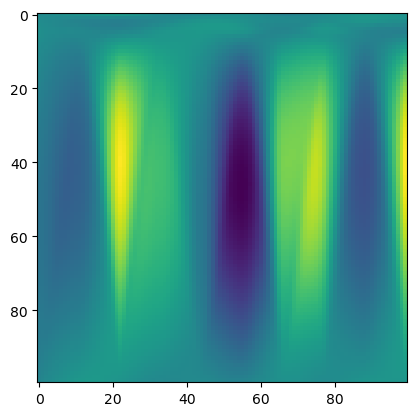

In [ ]:
x = np.linspace(0, 10, 10)  # Linearly spaced x
y = np.array([1, 2, 4, 6, 70.8])  # Non-uniform y
z = np.random.rand(5, 10)  # Your data matrix
xi, yi, zi=interpolate_to_uniform_grid(x,y,z)
plt.imshow(zi)